# 風險管理 作業二

<div style="text-align: right">B07607001 鄭鈞瀚</div>

Google Colab 線上版本： <a href="https://colab.research.google.com/drive/1dg0cSPAj4JkrcJ0H6kXdXgTr1_Usnr_d?usp=sharing"><img style="display: inline-block;" src="https://colab.research.google.com/assets/colab-badge.svg"></a>

Excel Data: [Google Drive Folder](https://drive.google.com/drive/folders/1sY6j5_TfF-qoYUjYqrWbx99Io1F02hdd?usp=sharing)

## 設定亂數種子



In [1]:
seed = 0
encode_string = "率慈是我們的偶像，我愛風險管理"

for character in encode_string:
    seed += ord(character)
print(f"Seed: {seed}")

Seed: 452122


## Import Third-Party Packages



In [2]:
# 移除無用警告
import warnings
warnings.filterwarnings('ignore')

# Pandas: 資料處理用途
import pandas as pd
# Matplotlib: 資料視覺化
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Helvetica"]
plt.rcParams["axes.unicode_minus"] = False
plt.style.use("seaborn")

from IPython.display import set_matplotlib_formats

%matplotlib inline
set_matplotlib_formats("svg")

# Sklearn: 迴歸分析, MSE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# Seaborn: 資料視覺化
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
# Numpy: 數學計算, 統計亂數
import numpy as np
# statsmodels: 統計
import statsmodels.api as sm

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Log-normal 轉換

* $\mu = \ln(\frac{m}{\sqrt{1+\frac{v}{m^2}}})$

* $\sigma = \sqrt{\ln(1 + \frac{v}{m^2})}$

In [4]:
def lognorm_params(mode: float, stddev: float):
    """
    Transform mode and std to lognormal's form

    Args:
        mode(float): 平均數
        stddev(float): 標準差
    Return:
        mu(float): Log-normal 平均數
        sigma(float): Log-normal 標準差
    """
    p = np.poly1d([1, -1, 0, 0, -(stddev/mode)**2])
    r = p.roots
    sol = r[(r.imag == 0) & (r.real > 0)].real
    mu = np.log(mode * sol)
    sigma = np.sqrt(np.log(sol))
    return mu, sigma

## Step 0

資料來源： [USDA ERS - Fruit and Tree Nuts Yearbook Tables](https://www.ers.usda.gov/data-products/fruit-and-tree-nuts-data/fruit-and-tree-nuts-yearbook-tables/)

In [5]:
content_df = pd.read_excel("https://www.ers.usda.gov/webdocs/DataFiles/54499/FruitYearbookCitrusFruit_CTables.xlsx?v=5599.5", sheet_name="Content")
content_df = content_df.rename(columns={"Citrus Fruit: Production, bearing acreage, yield per acre, equivalent-on-tree returns, and juice stock, pack, and movement": "Content"})
content_df

,Content
0,Table C-1--Grapefruit: Bearing acreage and yie...
1,"Table C-2--Grapefruit: Production by State, 19..."
2,Table C-3--Grapefruit: Utilization of producti...
3,Table C-4--Grapefruit: Equivalent-on-tree retu...
4,Table C-5--All grapefruit: Monthly equivalent-...
5,Table C-6--All grapefruit: Monthly equivalent-...
6,Table C-7--All grapefruit: Monthly equivalent-...
7,Table C-8--All grapefruit: Monthly equivalent-...
8,Table C-9--All grapefruit: Monthly equivalent-...
9,"Table C-10--Processed grapefruit: Florida, 198..."


## Question 1

> Background - What are the varieties in Citrus fruit category? What are the primary production states?

資料中共包含 `Grapefruit`, `Lemon` 和 `Orange` 三種作物作物，以下將分項探討

### Grapefruit

在 `Grapefruit` 類別中，我們可以觀察到 `Florida` 是最大的生產州，其佔了77.8%的生產比例

In [6]:
df = pd.read_excel("gdrive/MyDrive/風險管理/Production.xlsx", sheet_name="Grapefruit")
df.describe()

,Florida,California,Texas,Arizona,United States
count,40.000000,40.000000,38.000000,29.000000,40.000000
mean,1475.393750,225.346875,206.857895,46.333879,1923.963750
std,734.766114,56.410301,99.068482,36.551684,793.000968
min,164.900000,150.750000,2.600000,0.837500,508.900000
25%,815.468750,175.550000,177.500000,5.360000,1224.968750
50%,1738.250000,207.700000,210.000000,46.900000,2174.625000
75%,2108.406250,268.837500,243.000000,77.000000,2610.000000
max,2371.500000,329.750000,556.000000,107.000000,2912.000000


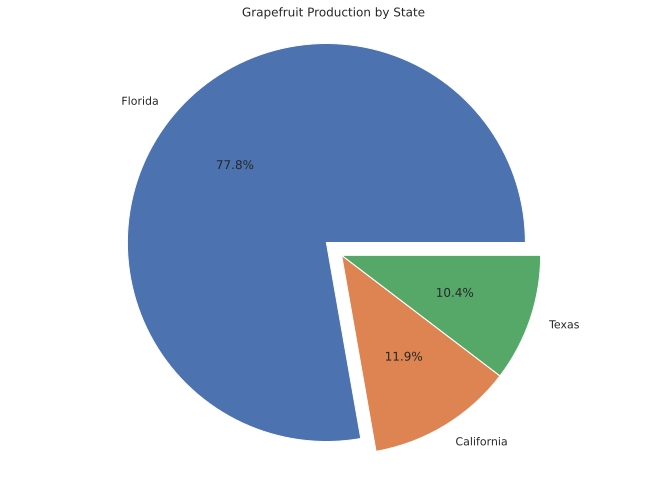

In [7]:
labels = ["Florida", "California", "Texas"]
sizes = [df["Florida"].sum(),
         df["California"].sum(),
         df["Texas"].sum()]
fig1, ax1 = plt.subplots()
separated = (.1,0, 0)
ax1.pie(sizes, labels=labels, autopct="%1.1f%%", explode=separated)
ax1.axis("equal")
plt.title("Grapefruit Production by State")
plt.show()

### Lemon

在 `Lemon` 類別中，我們可以觀察到僅有 `California` 和 `Arizona` 兩州生產，其中以 `California` 生產較多

In [8]:
df = pd.read_excel("gdrive/MyDrive/風險管理/Production.xlsx", sheet_name="Lemon")
df.describe()

,California,Arizona,United States
count,40.000000,40.000000,40.000000
mean,761.900000,125.200000,887.025000
std,111.416935,58.738971,118.492775
min,562.000000,30.000000,619.000000
25%,692.250000,83.000000,798.000000
50%,783.000000,114.000000,897.000000
75%,827.000000,147.000000,963.250000
max,1028.000000,270.000000,1189.000000


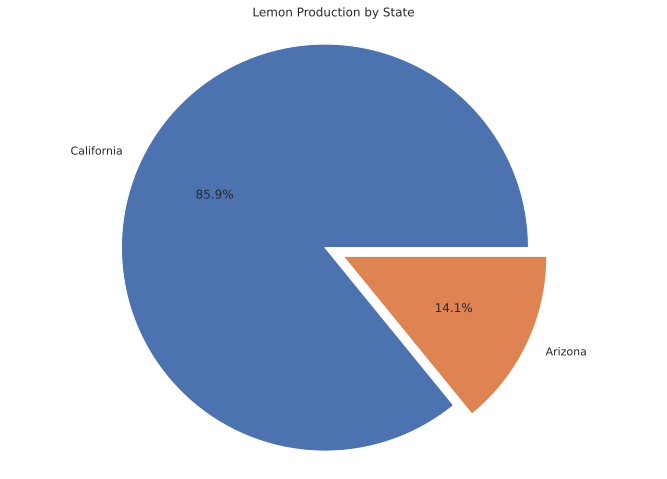

In [9]:
labels = ["California", "Arizona"]
sizes = [df["California"].sum(),
         df["Arizona"].sum()]
fig1, ax1 = plt.subplots()
separated = (.1,0)
ax1.pie(sizes, labels=labels, autopct="%1.1f%%", explode=separated)
ax1.axis("equal")
plt.title("Lemon Production by State")
plt.show()

### Orange

在 `Orange` 類別中，`Florida` 仍為最大生產州，占 75.3% 比例

In [10]:
df = pd.read_excel("gdrive/MyDrive/風險管理/Production.xlsx", sheet_name="Orange")
df.describe()

,Florida,California,Texas,Arizona,United States
count,40.000000,40.000000,38.000000,29.000000,40.000000
mean,6739.762500,2133.965625,75.921184,54.960345,8985.172125
std,2319.255266,362.916848,50.547718,33.809086,2407.400116
min,2027.250000,961.000000,1.275000,9.375000,3875.150000
25%,5336.000000,1931.812500,58.745625,22.100000,7569.337500
50%,6459.750000,2173.500000,68.743750,59.000000,8929.012500
75%,8376.750000,2388.750000,78.332500,71.250000,10613.250000
max,10980.000000,2853.750000,252.450000,142.000000,13670.000000


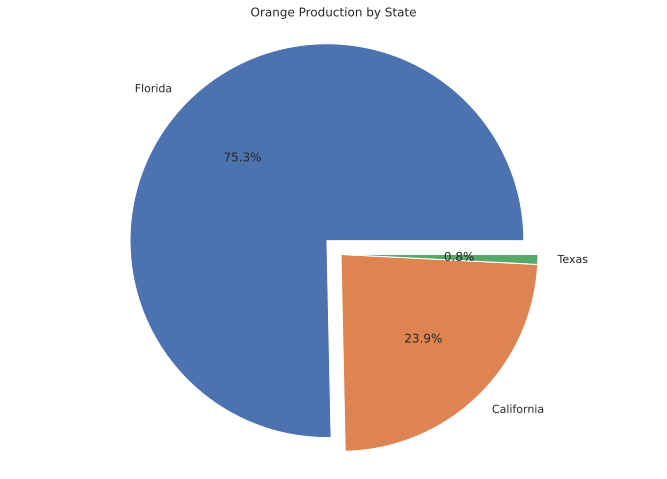

In [11]:
labels = ["Florida", "California", "Texas"]
sizes = [df["Florida"].sum(),
         df["California"].sum(),
         df["Texas"].sum()]
fig1, ax1 = plt.subplots()
separated = (.1,0, 0)
ax1.pie(sizes, labels=labels, autopct="%1.1f%%", explode=separated)
ax1.axis("equal")
plt.title("Orange Production by State")
plt.show()

## Question 2

> Derive returns per acre for each Citrus fruit for each state – Pay attention to the footnotes under Tables, you will be able to derive this value. One Annual Summary is in the Folder, which you can use to double check your answer. Next, divide this returns by usage purpose, fresh and processing, by using the data on utilization (Think how you can do it). Run simple regression of returns per acre on years and states. Concisely explain the potential year and state effects on revenues, albeit it’s not the farm level.

> > Hint: What do you need to do in cleaning data given prices across years? Because this is the supply-side information, what’s the inflation adjustment base for agricultural commodities compared to the common Consumer Price Index? Use 2015 as the base year. Here we assume fresh fruit is dominant in the marketplace, use category rather than single variety as your reference, and match with the starting year in the production information. Locate data on US Bureau of Labor Statistics: https://www.bls.gov. Specify clearly what data you choose to use to COMBINE with the Citrus Fruits production data from Question 1. Argue why we cannot simply draw the data from the same source on ERS, at the Food Prices Outlook section: https://www.ers.usda.gov/data-products/food-price-outlook/

### Return per acre

結果請參見 [Excel Data](https://drive.google.com/file/d/1RtREpiIVc8iHhRKDEpF-y0-4elM89Aec/view?usp=sharing)

### Simple Regression

#### Grapefruit

##### Import Grapefruit data and adjust data

In [12]:
df = pd.read_excel("gdrive/MyDrive/風險管理/Return per acre.xlsx", sheet_name="Grapefruit")
del df["Dollars / Box"]
del df["PPI (2015 base)"]
del df["Box weight (pounds)"]
del df["Yield per acre (tons)"]
del df["Bearing acre (1000 acre)"]
del df["Total Return"]

# Drop N/A
df=df.dropna()
df.dtypes

State               object
Year                 int64
Return per acre    float64
dtype: object

##### `State` and `Year` as x input

In [13]:
X = pd.get_dummies(data=df, columns=["State", "Year"], drop_first=True)
del X["Return per acre"]
X

,State_California,State_Florida,State_Texas,State_United States,Year_1981,Year_1982,Year_1983,Year_1984,Year_1985,Year_1986,Year_1987,Year_1988,Year_1989,Year_1990,Year_1991,Year_1992,Year_1993,Year_1994,Year_1995,Year_1996,Year_1997,Year_1998,Year_1999,Year_2000,Year_2001,Year_2002,Year_2003,Year_2004,Year_2005,Year_2006,Year_2007,Year_2008,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
196,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
197,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
198,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


##### `Return per acre` as y output

In [14]:
Y = df["Return per acre"]
Y

0      3047.627644
1      1665.700072
2      1284.080973
3      1975.512948
4      2856.280529
          ...     
195    3228.826006
196    3019.524219
197    2250.321514
198    2156.769673
199    2734.720986
Name: Return per acre, Length: 186, dtype: float64

##### Subsets

在這裡我們取 80% 作為訓練樣本，20% 作為測試

In [15]:
from sklearn.model_selection import train_test_split
# Random state as seed
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=2021)

##### Linear Regression

###### Model Training

In [16]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [17]:
print(model.intercept_)

1267.5086559183246


###### Model Prediction

[Text(0, 0.5, 'Predict Value'), Text(0.5, 0, 'Actual Value')]

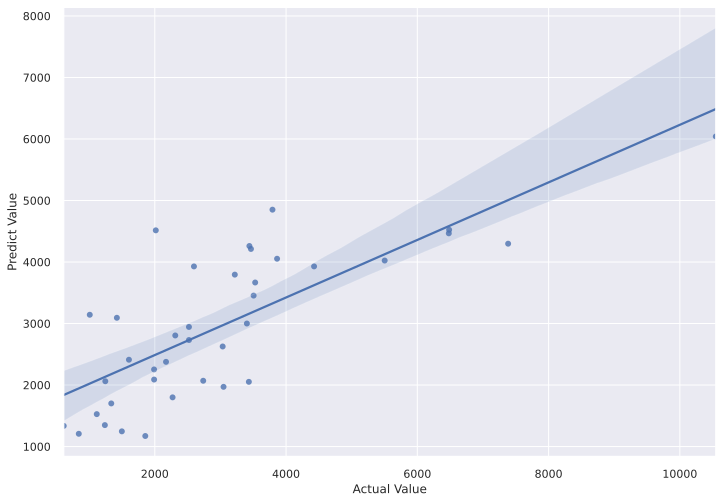

In [18]:
predictions = model.predict(X_test)
ax = sns.regplot(y_test, predictions)
ax.set(xlabel="Actual Value", ylabel="Predict Value")

###### Model Summary

In [19]:
X_train_Sm= sm.add_constant(X_train)
ls=sm.OLS(y_train,X_train_Sm).fit()
ls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Return per acre   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     5.658
Date:                Sat, 05 Jun 2021   Prob (F-statistic):           2.78e-13
Time:                        05:28:21   Log-Likelihood:                -1200.7
No. Observations:                 148   AIC:                             2489.
Df Residuals:                     104   BIC:                             2621.
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1267.5087    581.870      2.178      0.032     113.638    2421.379
State_California     2483.5988    294.748      8.426      0.000    1899.103    3068.094
State_Florida         703.4064    278.897      2.522      0.013     150.344    1256.469
State_Texas           259.5028    285.035      0.910      0.365    -305.732     824.737
State_United States   917.4532    278.897      3.290      0.001     364.391    1470.516
Year_1981            -937.7082    741.102     -1.265      0.209   -2407.342     531.925
Year_1982            -657.8642    741.786     -0.887      0.377   -2128.854     813.126
Year_1983            -568.8666    706.891     -0.805      0.423   -1970.658     832.924
Year_1984            1609.9503    790.810      2.036      0.044      41.744    3178.157
Year_1985             645.8796    706.891      0.914      0.363    -755.911    2047.671
Year_1986            1250.1952    706.891      1.769      0.080    -151.596    2651.986
Year_1987            1278.9353    737.708      1.734      0.086    -183.968    2741.838
Year_1988              81.2096    792.461      0.102      0.919   -1490.270    1652.689
Year_1989            1615.5066    737.708      2.190      0.031     152.603    3078.410
Year_1990             904.0498    737.708      1.225      0.223    -558.853    2366.953
Year_1991             177.1634    741.786      0.239      0.812   -1293.827    1648.153
Year_1992             461.3198    741.786      0.622      0.535   -1009.670    1932.310
Year_1993              98.8177    737.849      0.134      0.894   -1364.365    1562.001
Year_1994             -95.8786    796.498     -0.120      0.904   -1675.363    1483.606
Year_1995             -59.9813    742.522     -0.081      0.936   -1532.430    1412.467
Year_1996            -751.0041    741.786     -1.012      0.314   -2221.994     719.986
Year_1997              46.7989    706.891      0.066      0.947   -1354.992    1448.590
Year_1998             546.6585    795.757      0.687      0.494   -1031.357    2124.674
Year_1999             -84.3096    741.786     -0.114      0.910   -1555.300    1386.680
Year_2000             534.6181    737.708      0.725      0.470    -928.285    1997.521
Year_2001              68.5540    796.498      0.086      0.932   -1510.931    1648.038
Year_2002             440.5185    737.849      0.597      0.552   -1022.665    1903.702
Year_2003            1269.1318    741.102      1.712      0.090    -200.502    2738.765
Year_2004            2289.3526    791.716      2.892      0.005     719.350    3859.355
Year_2005            3247.4979    742.522      4.374      0.000    1775.050    4719.946
Year_2006             715.1553    741.786      0.964      0.337    -755.835    2186.145
Year_2007             433.4555    742.522      0.584      0.561   -1038.993    1905.904
Yea

#### Lemon

##### Import Lemon data and adjust data

In [20]:
df = pd.read_excel("gdrive/MyDrive/風險管理/Return per acre.xlsx", sheet_name="Lemon")
del df["Dollars / Box"]
del df["PPI (2015 base)"]
del df["Box weight (pounds)"]
del df["Yield per acre (tons)"]
del df["Bearing acre (1000 acre)"]
del df["Total Return"]

# Drop N/A
df=df.dropna()
df.dtypes

State               object
Year                 int64
Return per acre    float64
dtype: object

##### `State` and `Year` as x input

In [21]:
X = pd.get_dummies(data=df, columns=["State", "Year"], drop_first=True)
del X["Return per acre"]
X

,State_California,State_United States,Year_1981,Year_1982,Year_1983,Year_1984,Year_1985,Year_1986,Year_1987,Year_1988,Year_1989,Year_1990,Year_1991,Year_1992,Year_1993,Year_1994,Year_1995,Year_1996,Year_1997,Year_1998,Year_1999,Year_2000,Year_2001,Year_2002,Year_2003,Year_2004,Year_2005,Year_2006,Year_2007,Year_2008,Year_2009,Year_2010,Year_2011,Year_2012,Year_2016,Year_2017,Year_2018,Year_2019
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
116,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
117,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
118,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


##### `Return per acre` as y output

In [22]:
Y = df["Return per acre"]
Y

0      2084.738249
1      1185.511308
2      1018.211630
3      2428.000136
4      3619.092143
          ...     
112    6297.650897
116    9791.412146
117    7397.001644
118    6604.572912
119    7552.463230
Name: Return per acre, Length: 111, dtype: float64

##### Subsets

在這裡我們取 80% 作為訓練樣本，20% 作為測試

In [23]:
from sklearn.model_selection import train_test_split
# Random state as seed
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=2021)

##### Linear Regression

###### Model Training

In [24]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [25]:
print(model.intercept_)

-327.7689439490923


###### Model Prediction

[Text(0, 0.5, 'Predict Value'), Text(0.5, 0, 'Actual Value')]

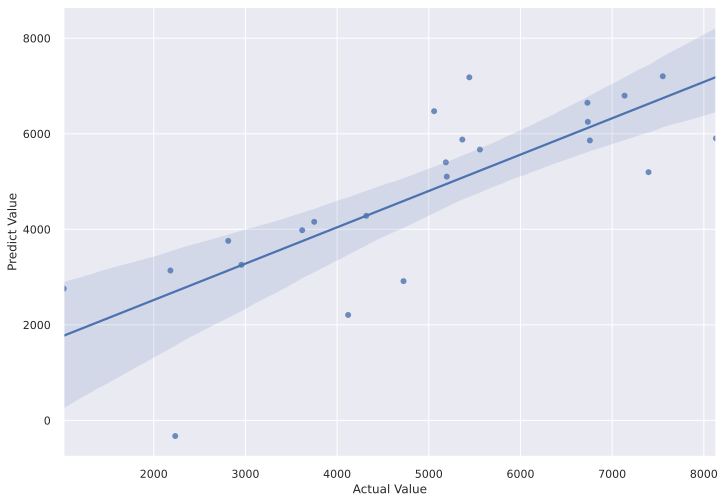

In [26]:
predictions = model.predict(X_test)
ax = sns.regplot(y_test, predictions)
ax.set(xlabel="Actual Value", ylabel="Predict Value")

###### Model Summary

In [27]:
X_train_Sm= sm.add_constant(X_train)
ls=sm.OLS(y_train,X_train_Sm).fit()
ls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Return per acre   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     10.57
Date:                Sat, 05 Jun 2021   Prob (F-statistic):           1.20e-13
Time:                        05:28:22   Log-Likelihood:                -712.68
No. Observations:                  88   AIC:                             1501.
Df Residuals:                      50   BIC:                             1595.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -327.7689    630.870     -0.520      0.606   -1594.909     939.371
State_California     3242.8361    278.904     11.627      0.000    2682.642    3803.030
State_United States  2534.6573    296.352      8.553      0.000    1939.418    3129.897
Year_1981            -817.3184    862.310     -0.948      0.348   -2549.319     914.683
Year_1982            -158.2828    967.808     -0.164      0.871   -2102.183    1785.617
Year_1983              87.0180    862.310      0.101      0.920   -1644.983    1819.019
Year_1984            1065.2830    967.808      1.101      0.276    -878.617    3009.183
Year_1985            2930.0541    862.310      3.398      0.001    1198.053    4662.055
Year_1986            1049.9747    968.240      1.084      0.283    -894.793    2994.743
Year_1987            1949.2068    968.240      2.013      0.049       4.439    3893.975
Year_1988            5.229e-13   2.23e-13      2.342      0.023    7.44e-14    9.71e-13
Year_1989            3462.2852    968.240      3.576      0.001    1517.517    5407.053
Year_1990            3194.7147    968.240      3.300      0.002    1249.947    5139.483
Year_1991            1522.9321    862.310      1.766      0.083    -209.069    3254.933
Year_1992            2968.3672    862.310      3.442      0.001    1236.366    4700.368
Year_1993            4265.6158   1230.189      3.467      0.001    1794.708    6736.524
Year_1994            3582.5887    862.310      4.155      0.000    1850.588    5314.590
Year_1995            3321.3660    862.310      3.852      0.000    1589.365    5053.367
Year_1996            3294.4331    862.310      3.820      0.000    1562.432    5026.434
Year_1997            2485.5077    862.310      2.882      0.006     753.507    4217.509
Year_1998            3671.3004    968.240      3.792      0.000    1726.533    5616.068
Year_1999            2510.8316    862.310      2.912      0.005     778.831    4242.833
Year_2000            2126.1952    862.310      2.466      0.017     394.194    3858.196
Year_2001            3929.7424    862.310      4.557      0.000    2197.741    5661.743
Year_2002            2187.7886    967.808      2.261      0.028     243.888    4131.689
Year_2003            3464.6824    967.484      3.581      0.001    1521.433    5407.931
Year_2004            2075.5030    968.240      2.144      0.037     130.735    4020.271
Year_2005            3652.5280    968.240      3.772      0.000    1707.760    5597.296
Year_2006            4441.7192    968.240      4.587      0.000    2496.951    6386.487
Year_2007            5891.7608    862.310      6.833      0.000    4159.760    7623.762
Year_2008            2229.6196    862.310      2.586      0.013     497.619    3961.621
Year_2009            3476.7224    862.310      4.032      0.000    1744.721    5208.723
Yea

#### Orange

##### Import Orange data and adjust data

In [28]:
df = pd.read_excel("gdrive/MyDrive/風險管理/Return per acre.xlsx", sheet_name="Orange")
del df["Dollars / Box"]
del df["PPI (2015 base)"]
del df["Box weight (pounds)"]
del df["Yield per acre (tons)"]
del df["Bearing acre (1000 acre)"]
del df["Total Return"]

# Drop N/A
df=df.dropna()
df.dtypes

State               object
Year                 int64
Return per acre    float64
dtype: object

##### `State` and `Year` as x input

In [29]:
X = pd.get_dummies(data=df, columns=["State", "Year"], drop_first=True)
del X["Return per acre"]
X

,State_California,State_Florida,State_Texas,State_United States,Year_1981,Year_1982,Year_1983,Year_1984,Year_1985,Year_1986,Year_1987,Year_1988,Year_1989,Year_1990,Year_1991,Year_1992,Year_1993,Year_1994,Year_1995,Year_1996,Year_1997,Year_1998,Year_1999,Year_2000,Year_2001,Year_2002,Year_2003,Year_2004,Year_2005,Year_2006,Year_2007,Year_2008,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
196,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
197,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
198,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


##### `Return per acre` as y output

In [30]:
Y = df["Return per acre"]
Y

0      2567.386245
1      2035.498171
2      2864.777683
3      3006.075006
4      3587.829189
          ...     
195    2728.517987
196    2552.293214
197    2102.370287
198    1765.674552
199    2332.952008
Name: Return per acre, Length: 187, dtype: float64

##### Subsets

在這裡我們取 80% 作為訓練樣本，20% 作為測試

In [31]:
from sklearn.model_selection import train_test_split
# Random state as seed
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=2021)

##### Linear Regression

###### Model Training

In [32]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [33]:
print(model.intercept_)

840.6136643330105


###### Model Prediction

[Text(0, 0.5, 'Predict Value'), Text(0.5, 0, 'Actual Value')]

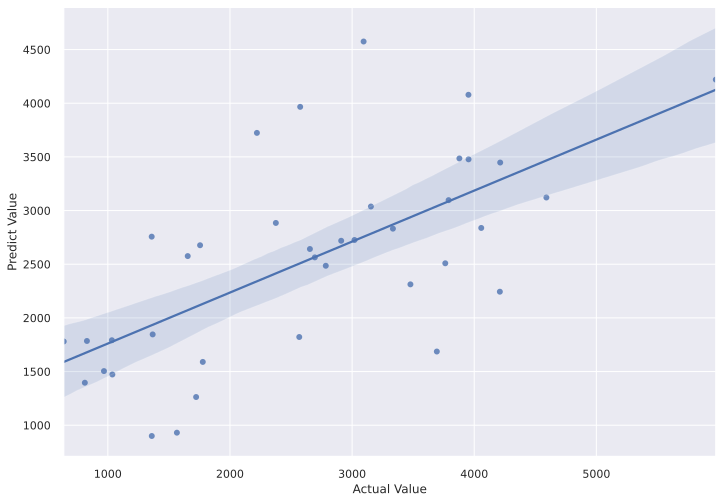

In [34]:
predictions = model.predict(X_test)
ax = sns.regplot(y_test, predictions)
ax.set(xlabel="Actual Value", ylabel="Predict Value")

###### Model Summary

In [35]:
X_train_Sm= sm.add_constant(X_train)
ls=sm.OLS(y_train,X_train_Sm).fit()
ls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Return per acre   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     7.979
Date:                Sat, 05 Jun 2021   Prob (F-statistic):           2.69e-18
Time:                        05:28:23   Log-Likelihood:                -1145.1
No. Observations:                 149   AIC:                             2378.
Df Residuals:                     105   BIC:                             2510.
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 840.6137    377.445      2.227      0.028      92.210    1589.018
State_California     1966.6375    186.268     10.558      0.000    1597.303    2335.972
State_Florida         981.3090    175.813      5.582      0.000     632.704    1329.914
State_Texas            58.9841    180.015      0.328      0.744    -297.952     415.920
State_United States  1246.0397    175.485      7.101      0.000     898.085    1593.995
Year_1981             798.0564    482.584      1.654      0.101    -158.819    1754.932
Year_1982             916.6288    482.973      1.898      0.060     -41.018    1874.276
Year_1983             808.0932    460.243      1.756      0.082    -104.484    1720.670
Year_1984            1992.3485    514.945      3.869      0.000     971.307    3013.390
Year_1985             289.6803    460.243      0.629      0.530    -622.896    1202.257
Year_1986             940.1767    460.243      2.043      0.044      27.600    1852.753
Year_1987            1676.4033    480.327      3.490      0.001     724.004    2628.802
Year_1988             422.0983    579.238      0.729      0.468    -726.424    1570.620
Year_1989             885.3599    480.327      1.843      0.068     -67.039    1837.759
Year_1990            1204.8794    480.327      2.508      0.014     252.480    2157.279
Year_1991            -130.2433    482.973     -0.270      0.788   -1087.890     827.404
Year_1992             678.2736    482.973      1.404      0.163    -279.373    1635.921
Year_1993             741.9493    480.425      1.544      0.126    -210.644    1694.543
Year_1994             632.0436    518.503      1.219      0.226    -396.052    1660.139
Year_1995             951.1856    518.503      1.834      0.069     -76.910    1979.281
Year_1996             289.9612    482.973      0.600      0.550    -667.686    1247.608
Year_1997             708.5528    460.243      1.540      0.127    -204.024    1621.130
Year_1998            1768.0264    482.973      3.661      0.000     810.379    2725.673
Year_1999             -50.2961    482.973     -0.104      0.917   -1007.943     907.351
Year_2000             880.8208    480.327      1.834      0.070     -71.578    1833.220
Year_2001             555.3257    518.503      1.071      0.287    -472.770    1583.421
Year_2002            -232.1472    480.425     -0.483      0.630   -1184.741     720.446
Year_2003             639.1568    482.584      1.324      0.188    -317.719    1596.032
Year_2004              24.1894    515.502      0.047      0.963    -997.957    1046.336
Year_2005             567.6734    460.243      1.233      0.220    -344.903    1480.250
Year_2006            1159.2493    482.973      2.400      0.018     201.602    2116.896
Year_2007             327.0080    460.243      0.711      0.479    -585.569    1239.585
Yea

## Question 3

> Derive utility levels for each Citrus fruit in each producing State, including US as a whole, using functions exhibiting CARA (one function) and CRRA (two functions). First to derive utilities, what might be the first assumption here given the available data at hand? For the CARA function, assume absolute risk aversion coefficient is 0.003, 0.001, 0.005. For CRRA function, assume r=0.1, 0.5, 0.9 for the function with a non-deterministic value for risk aversion coefficient. Use command twoway to compare utilities across different risk aversion levels under same function, and explain the graph if it makes sense. Under what production technologies, can we examine the utility levels with different levels of risk aversion? If functions represent production techniques, can we compare different technologies for the same fruit in one state or across states?

### First assumption

因原本 `CARA` 和 `CRRA` 函式中的 `w` 是指 wealth, 我們並沒有wealth的資料，只能使用 income 代替

### CARA Utility

Negative exponential: $U = 1 − exp(−cw), c > 0$

#### Grapefruit


In [36]:
df = pd.read_excel("gdrive/MyDrive/風險管理/Return per acre.xlsx", sheet_name="Grapefruit")

##### Florida

In [37]:
sub_df = df[df["State"] == "Florida"]
plot_df = pd.DataFrame(columns=["w", "Utility", "Risk averse coef."])
# c: 0.003
temp_utility = 1 - np.exp(-0.003 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.003})
plot_df = plot_df.append(temp)
# c: 0.001
temp_utility = 1 - np.exp(-0.001 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.001})
plot_df = plot_df.append(temp)
# c - 0.005
temp_utility = 1 - np.exp(-0.005 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.005})
plot_df = plot_df.append(temp)

Text(0.5, 1.0, 'Florida')

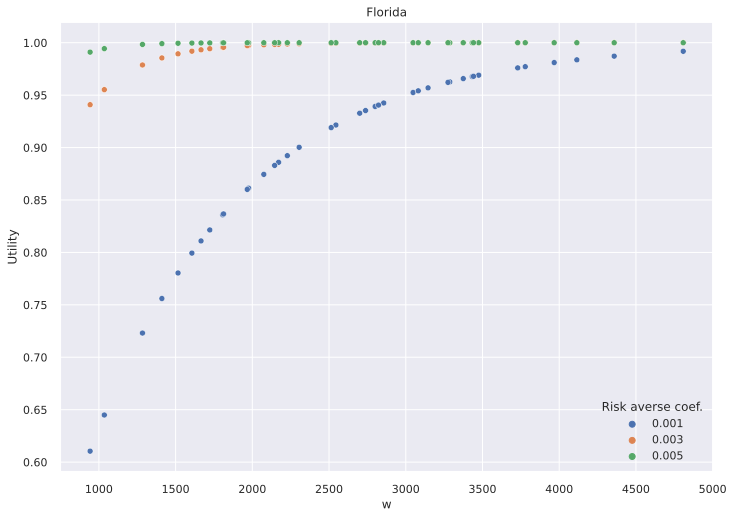

In [38]:
sns.scatterplot(data=plot_df, x="w", y="Utility", hue="Risk averse coef.", palette="deep").set_title('Florida')

##### California

In [39]:
sub_df = df[df["State"] == "California"]
plot_df = pd.DataFrame(columns=["w", "Utility", "Risk averse coef."])
# c: 0.003
temp_utility = 1 - np.exp(-0.003 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.003})
plot_df = plot_df.append(temp)
# c: 0.001
temp_utility = 1 - np.exp(-0.001 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.001})
plot_df = plot_df.append(temp)
# c - 0.005
temp_utility = 1 - np.exp(-0.005 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.005})
plot_df = plot_df.append(temp)

Text(0.5, 1.0, 'California')

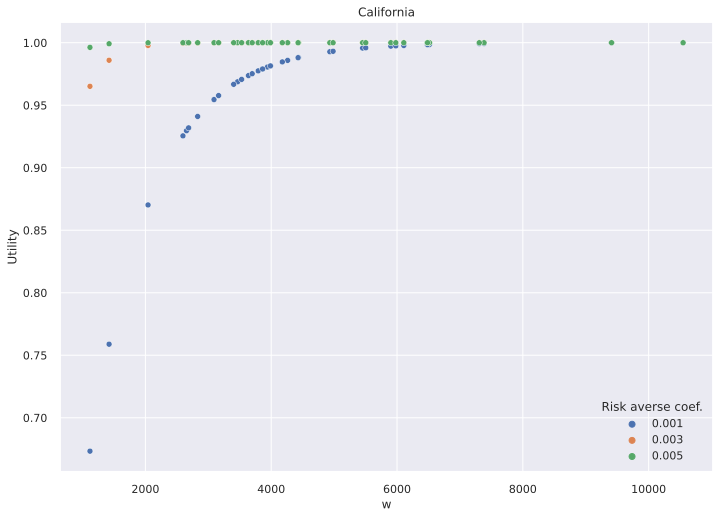

In [40]:
sns.scatterplot(data=plot_df, x="w", y="Utility", hue="Risk averse coef.", palette="deep").set_title('California')

##### Texas

In [41]:
sub_df = df[df["State"] == "Texas"]
plot_df = pd.DataFrame(columns=["w", "Utility", "Risk averse coef."])
# c: 0.003
temp_utility = 1 - np.exp(-0.003 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.003})
plot_df = plot_df.append(temp)
# c: 0.001
temp_utility = 1 - np.exp(-0.001 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.001})
plot_df = plot_df.append(temp)
# c - 0.005
temp_utility = 1 - np.exp(-0.005 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.005})
plot_df = plot_df.append(temp)

Text(0.5, 1.0, 'Texas')

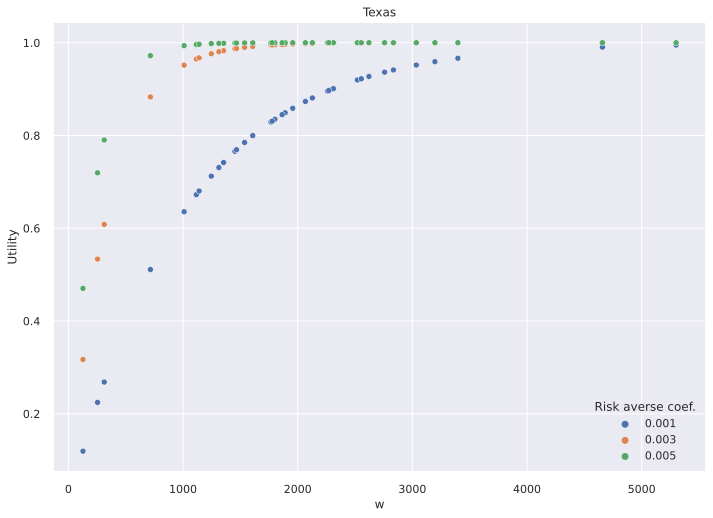

In [42]:
sns.scatterplot(data=plot_df, x="w", y="Utility", hue="Risk averse coef.", palette="deep").set_title('Texas')

##### Arizona

In [43]:
sub_df = df[df["State"] == "Arizona"]
plot_df = pd.DataFrame(columns=["w", "Utility", "Risk averse coef."])
# c: 0.003
temp_utility = 1 - np.exp(-0.003 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.003})
plot_df = plot_df.append(temp)
# c: 0.001
temp_utility = 1 - np.exp(-0.001 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.001})
plot_df = plot_df.append(temp)
# c - 0.005
temp_utility = 1 - np.exp(-0.005 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.005})
plot_df = plot_df.append(temp)

Text(0.5, 1.0, 'Arizona')

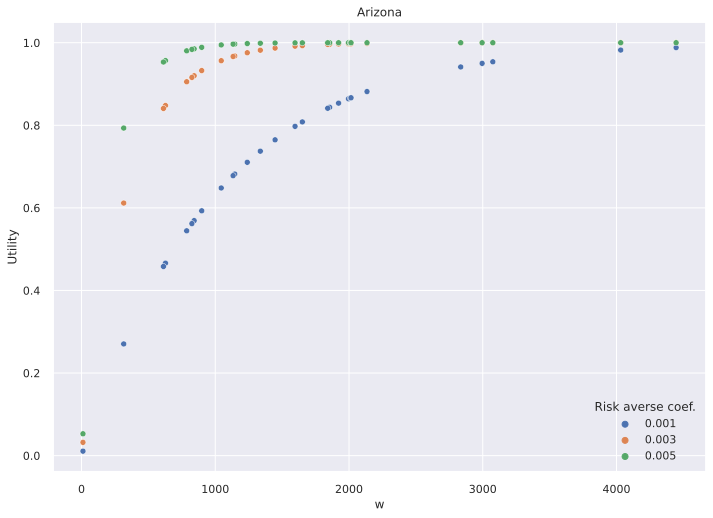

In [44]:
sns.scatterplot(data=plot_df, x="w", y="Utility", hue="Risk averse coef.", palette="deep").set_title('Arizona')

##### United States

In [45]:
sub_df = df[df["State"] == "United States"]
plot_df = pd.DataFrame(columns=["w", "Utility", "Risk averse coef."])
# c: 0.003
temp_utility = 1 - np.exp(-0.003 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.003})
plot_df = plot_df.append(temp)
# c: 0.001
temp_utility = 1 - np.exp(-0.001 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.001})
plot_df = plot_df.append(temp)
# c - 0.005
temp_utility = 1 - np.exp(-0.005 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.005})
plot_df = plot_df.append(temp)

Text(0.5, 1.0, 'United States')

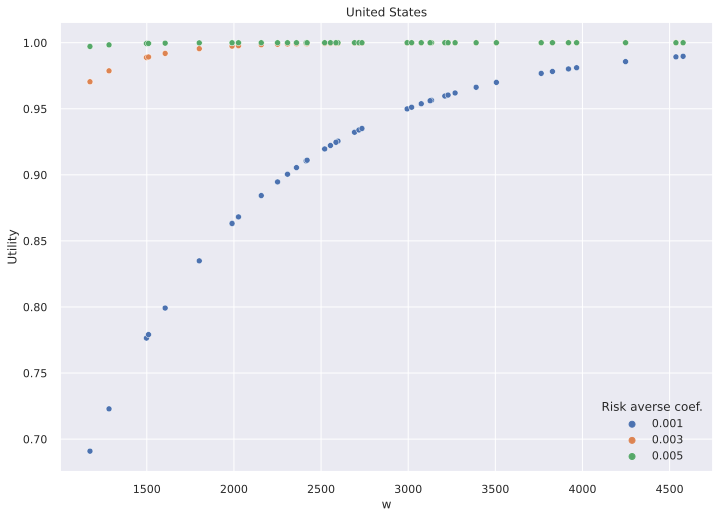

In [46]:
sns.scatterplot(data=plot_df, x="w", y="Utility", hue="Risk averse coef.", palette="deep").set_title('United States')

#### Lemon


In [47]:
df = pd.read_excel("gdrive/MyDrive/風險管理/Return per acre.xlsx", sheet_name="Lemon")

##### California

In [48]:
sub_df = df[df["State"] == "California"]
plot_df = pd.DataFrame(columns=["w", "Utility", "Risk averse coef."])
# c: 0.003
temp_utility = 1 - np.exp(-0.003 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.003})
plot_df = plot_df.append(temp)
# c: 0.001
temp_utility = 1 - np.exp(-0.001 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.001})
plot_df = plot_df.append(temp)
# c - 0.005
temp_utility = 1 - np.exp(-0.005 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.005})
plot_df = plot_df.append(temp)

Text(0.5, 1.0, 'California')

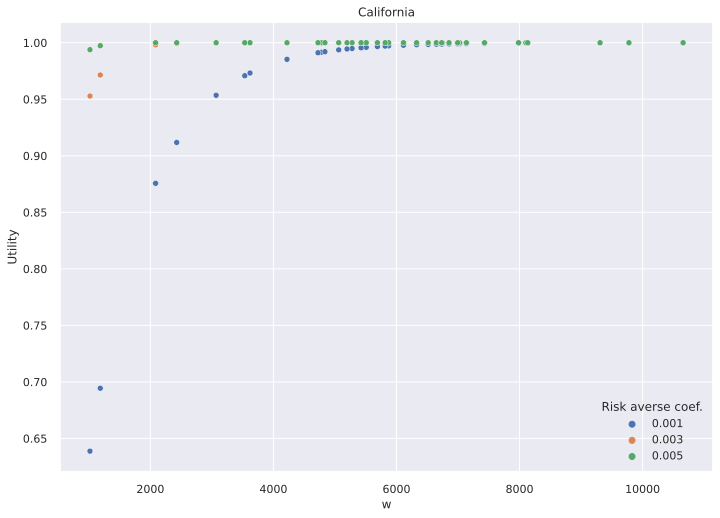

In [49]:
sns.scatterplot(data=plot_df, x="w", y="Utility", hue="Risk averse coef.", palette="deep").set_title('California')

##### Arizona

In [50]:
sub_df = df[df["State"] == "Arizona"]
plot_df = pd.DataFrame(columns=["w", "Utility", "Risk averse coef."])
# c: 0.003
temp_utility = 1 - np.exp(-0.003 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.003})
plot_df = plot_df.append(temp)
# c: 0.001
temp_utility = 1 - np.exp(-0.001 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.001})
plot_df = plot_df.append(temp)
# c - 0.005
temp_utility = 1 - np.exp(-0.005 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.005})
plot_df = plot_df.append(temp)

Text(0.5, 1.0, 'Arizona')

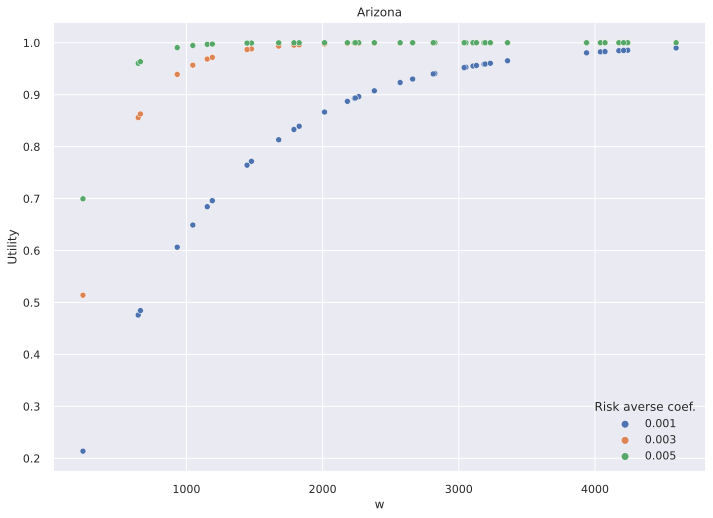

In [51]:
sns.scatterplot(data=plot_df, x="w", y="Utility", hue="Risk averse coef.", palette="deep").set_title('Arizona')

##### United States

In [52]:
sub_df = df[df["State"] == "United States"]
plot_df = pd.DataFrame(columns=["w", "Utility", "Risk averse coef."])
# c: 0.003
temp_utility = 1 - np.exp(-0.003 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.003})
plot_df = plot_df.append(temp)
# c: 0.001
temp_utility = 1 - np.exp(-0.001 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.001})
plot_df = plot_df.append(temp)
# c - 0.005
temp_utility = 1 - np.exp(-0.005 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.005})
plot_df = plot_df.append(temp)

Text(0.5, 1.0, 'United States')

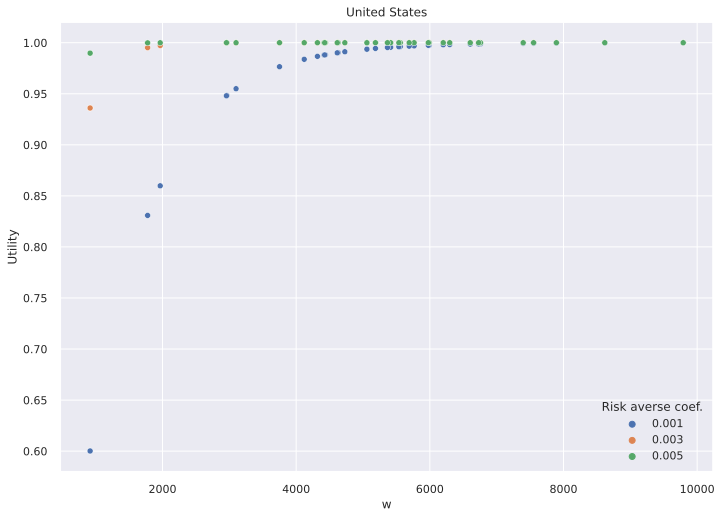

In [53]:
sns.scatterplot(data=plot_df, x="w", y="Utility", hue="Risk averse coef.", palette="deep").set_title('United States')

#### Orange


In [54]:
df = pd.read_excel("gdrive/MyDrive/風險管理/Return per acre.xlsx", sheet_name="Orange")

##### Florida

In [55]:
sub_df = df[df["State"] == "Florida"]
plot_df = pd.DataFrame(columns=["w", "Utility", "Risk averse coef."])
# c: 0.003
temp_utility = 1 - np.exp(-0.003 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.003})
plot_df = plot_df.append(temp)
# c: 0.001
temp_utility = 1 - np.exp(-0.001 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.001})
plot_df = plot_df.append(temp)
# c - 0.005
temp_utility = 1 - np.exp(-0.005 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.005})
plot_df = plot_df.append(temp)

Text(0.5, 1.0, 'Florida')

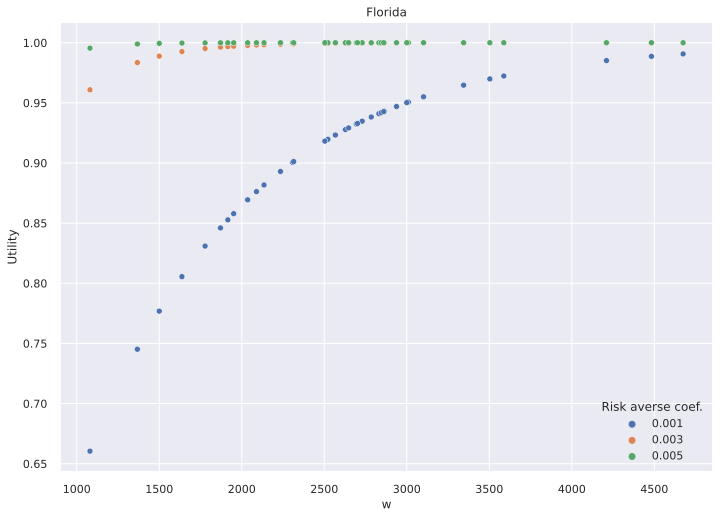

In [56]:
sns.scatterplot(data=plot_df, x="w", y="Utility", hue="Risk averse coef.", palette="deep").set_title('Florida')

##### California

In [57]:
sub_df = df[df["State"] == "California"]
plot_df = pd.DataFrame(columns=["w", "Utility", "Risk averse coef."])
# c: 0.003
temp_utility = 1 - np.exp(-0.003 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.003})
plot_df = plot_df.append(temp)
# c: 0.001
temp_utility = 1 - np.exp(-0.001 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.001})
plot_df = plot_df.append(temp)
# c - 0.005
temp_utility = 1 - np.exp(-0.005 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.005})
plot_df = plot_df.append(temp)

Text(0.5, 1.0, 'California')

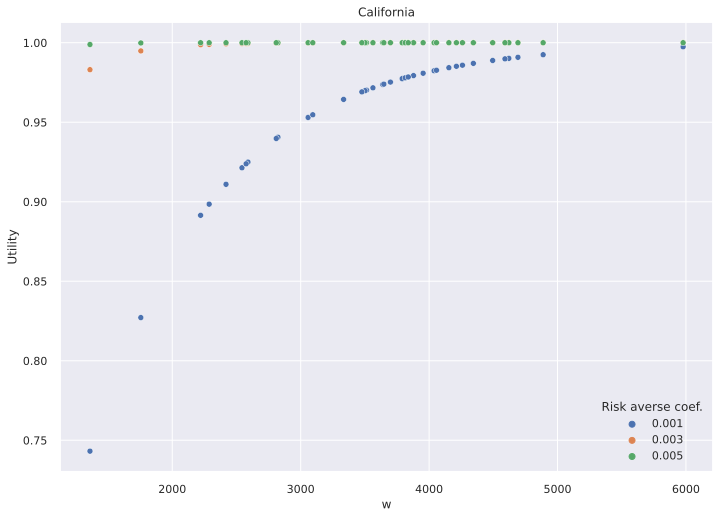

In [58]:
sns.scatterplot(data=plot_df, x="w", y="Utility", hue="Risk averse coef.", palette="deep").set_title('California')

##### Texas

In [59]:
sub_df = df[df["State"] == "Texas"]
plot_df = pd.DataFrame(columns=["w", "Utility", "Risk averse coef."])
# c: 0.003
temp_utility = 1 - np.exp(-0.003 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.003})
plot_df = plot_df.append(temp)
# c: 0.001
temp_utility = 1 - np.exp(-0.001 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.001})
plot_df = plot_df.append(temp)
# c - 0.005
temp_utility = 1 - np.exp(-0.005 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.005})
plot_df = plot_df.append(temp)

Text(0.5, 1.0, 'Texas')

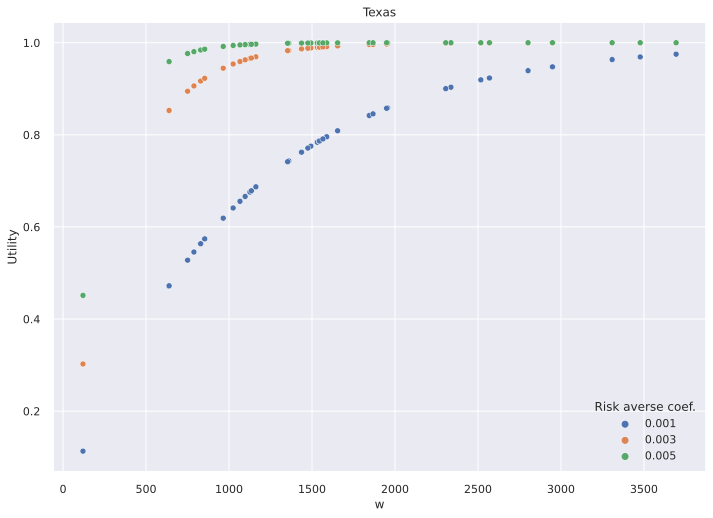

In [60]:
sns.scatterplot(data=plot_df, x="w", y="Utility", hue="Risk averse coef.", palette="deep").set_title('Texas')

##### Arizona

In [61]:
sub_df = df[df["State"] == "Arizona"]
plot_df = pd.DataFrame(columns=["w", "Utility", "Risk averse coef."])
# c: 0.003
temp_utility = 1 - np.exp(-0.003 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.003})
plot_df = plot_df.append(temp)
# c: 0.001
temp_utility = 1 - np.exp(-0.001 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.001})
plot_df = plot_df.append(temp)
# c - 0.005
temp_utility = 1 - np.exp(-0.005 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.005})
plot_df = plot_df.append(temp)

Text(0.5, 1.0, 'Arizona')

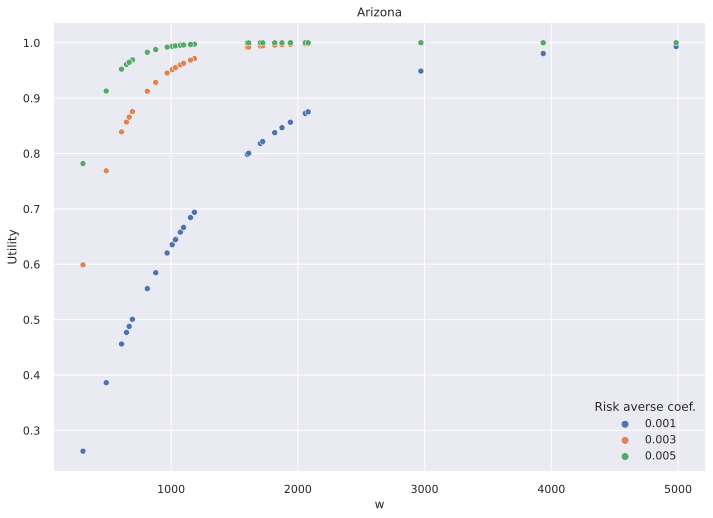

In [62]:
sns.scatterplot(data=plot_df, x="w", y="Utility", hue="Risk averse coef.", palette="deep").set_title('Arizona')

##### United States

In [63]:
sub_df = df[df["State"] == "United States"]
plot_df = pd.DataFrame(columns=["w", "Utility", "Risk averse coef."])
# c: 0.003
temp_utility = 1 - np.exp(-0.003 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.003})
plot_df = plot_df.append(temp)
# c: 0.001
temp_utility = 1 - np.exp(-0.001 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.001})
plot_df = plot_df.append(temp)
# c - 0.005
temp_utility = 1 - np.exp(-0.005 * sub_df["Return per acre"])
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.005})
plot_df = plot_df.append(temp)

Text(0.5, 1.0, 'United States')

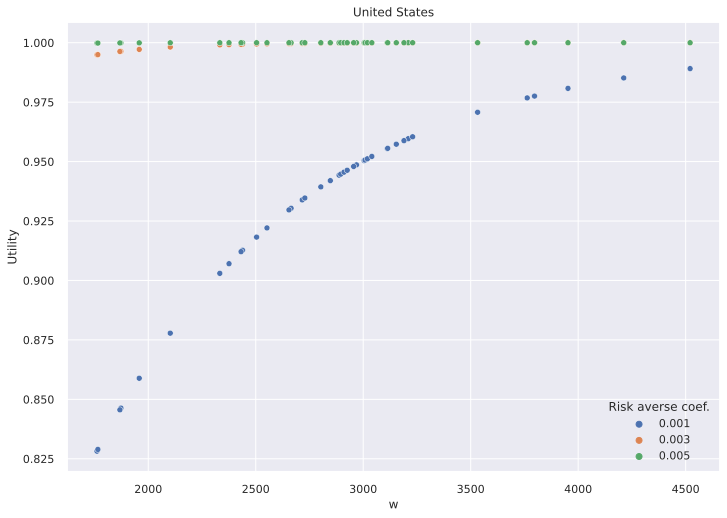

In [64]:
sns.scatterplot(data=plot_df, x="w", y="Utility", hue="Risk averse coef.", palette="deep").set_title('United States')

### CRRA Utility - Logarithmic

* Logarithmic: $U = ln(w), w > 0$ 
  
  for which $r_{a}(w) = w^{−1}$ and $r_{r}(w) = 1.0$.

#### Grapefruit

In [65]:
df = pd.read_excel("gdrive/MyDrive/風險管理/Return per acre.xlsx", sheet_name="Grapefruit")

##### Florida

In [66]:
temp = df[df["State"] == "Florida"]
plot_df = pd.DataFrame()
plot_df["w"] = temp["Return per acre"]
plot_df["Utility"] = np.log(temp["Return per acre"])

Text(0.5, 1.0, 'Florida')

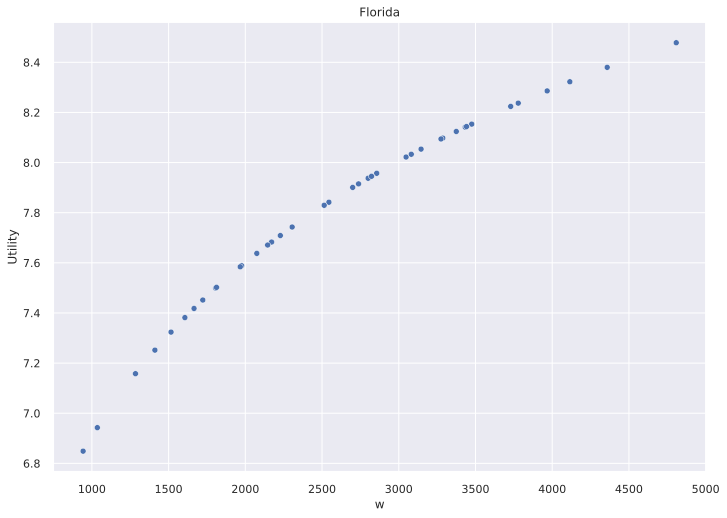

In [67]:
sns.scatterplot(data=plot_df, x="w", y="Utility", palette="deep").set_title('Florida')

##### California

In [68]:
temp = df[df["State"] == "California"]
plot_df = pd.DataFrame()
plot_df["w"] = temp["Return per acre"]
plot_df["Utility"] = np.log(temp["Return per acre"])

Text(0.5, 1.0, 'California')

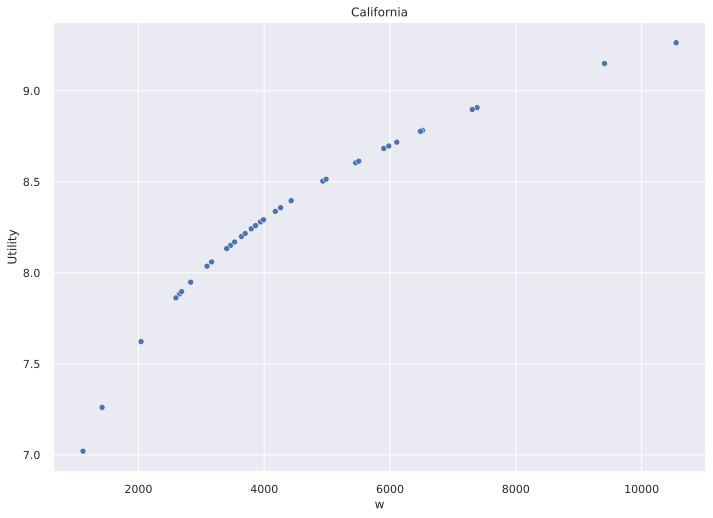

In [69]:
sns.scatterplot(data=plot_df, x="w", y="Utility", palette="deep").set_title('California')

##### Texas

In [70]:
temp = df[df["State"] == "Texas"]
plot_df = pd.DataFrame()
plot_df["w"] = temp["Return per acre"]
plot_df["Utility"] = np.log(temp["Return per acre"])

Text(0.5, 1.0, 'Texas')

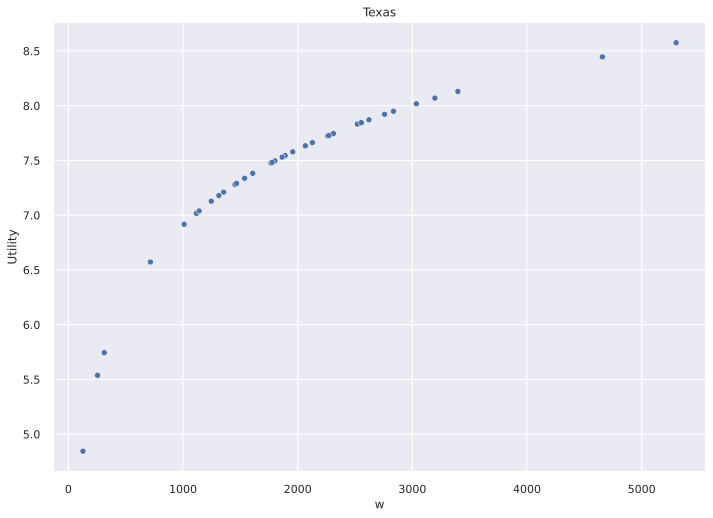

In [71]:
sns.scatterplot(data=plot_df, x="w", y="Utility", palette="deep").set_title('Texas')

##### Arizona

In [72]:
temp = df[df["State"] == "Arizona"]
plot_df = pd.DataFrame()
plot_df["w"] = temp["Return per acre"]
plot_df["Utility"] = np.log(temp["Return per acre"])

Text(0.5, 1.0, 'Arizona')

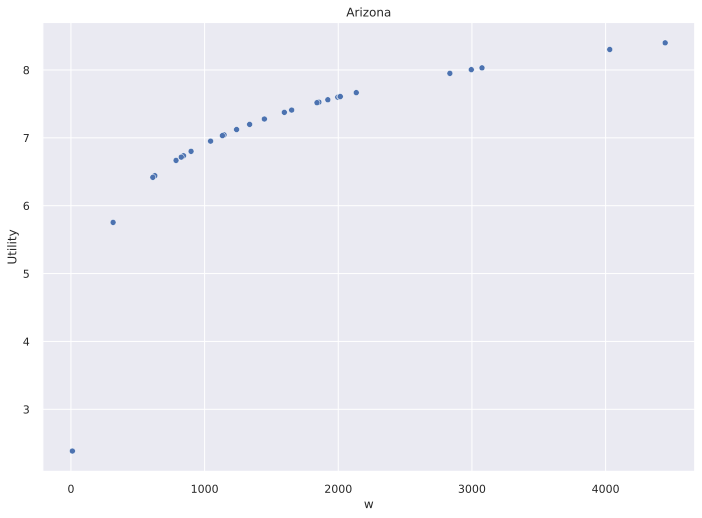

In [73]:
sns.scatterplot(data=plot_df, x="w", y="Utility", palette="deep").set_title('Arizona')

##### United States

In [74]:
temp = df[df["State"] == "United States"]
plot_df = pd.DataFrame()
plot_df["w"] = temp["Return per acre"]
plot_df["Utility"] = np.log(temp["Return per acre"])

Text(0.5, 1.0, 'United States')

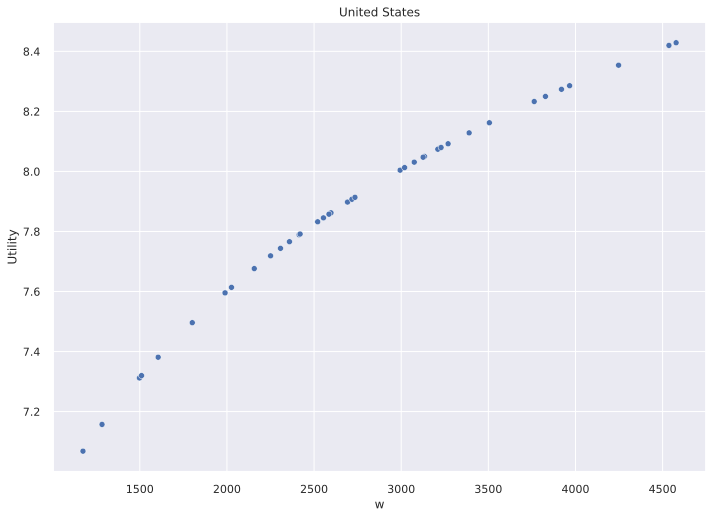

In [75]:
sns.scatterplot(data=plot_df, x="w", y="Utility", palette="deep").set_title('United States')

#### Lemon


In [76]:
df = pd.read_excel("gdrive/MyDrive/風險管理/Return per acre.xlsx", sheet_name="Lemon")

##### California

In [77]:
temp = df[df["State"] == "California"]
plot_df = pd.DataFrame()
plot_df["w"] = temp["Return per acre"]
plot_df["Utility"] = np.log(temp["Return per acre"])

Text(0.5, 1.0, 'California')

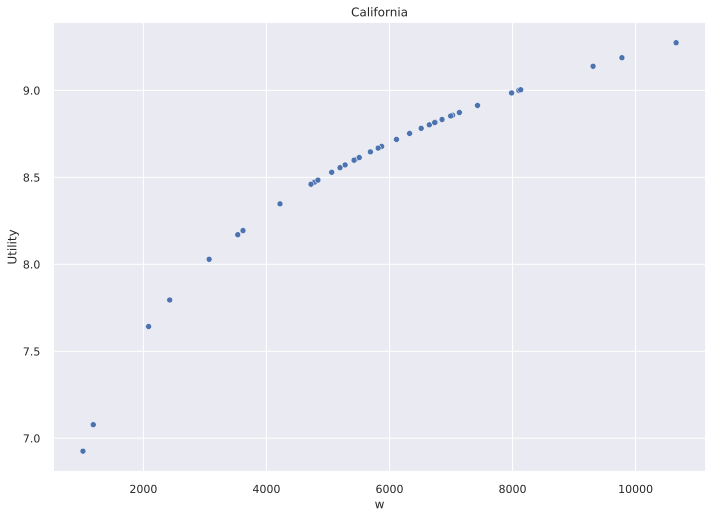

In [78]:
sns.scatterplot(data=plot_df, x="w", y="Utility", palette="deep").set_title('California')

##### Arizona

In [79]:
temp = df[df["State"] == "Arizona"]
plot_df = pd.DataFrame()
plot_df["w"] = temp["Return per acre"]
plot_df["Utility"] = np.log(temp["Return per acre"])

Text(0.5, 1.0, 'Arizona')

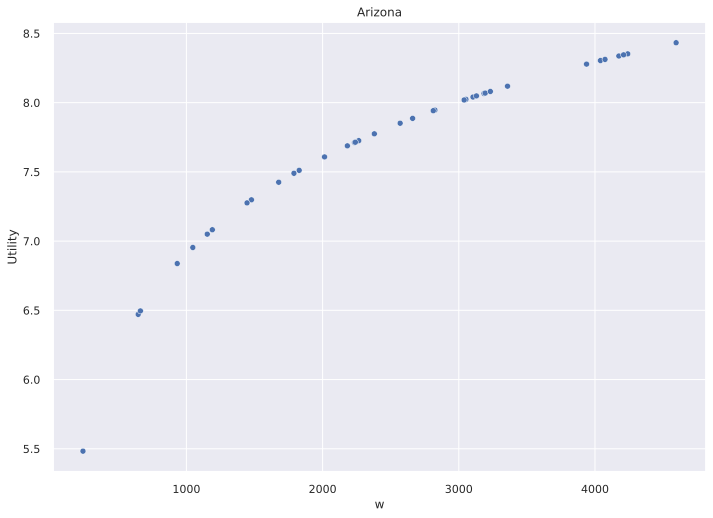

In [80]:
sns.scatterplot(data=plot_df, x="w", y="Utility", palette="deep").set_title('Arizona')

##### United States

In [81]:
temp = df[df["State"] == "United States"]
plot_df = pd.DataFrame()
plot_df["w"] = temp["Return per acre"]
plot_df["Utility"] = np.log(temp["Return per acre"])

Text(0.5, 1.0, 'United States')

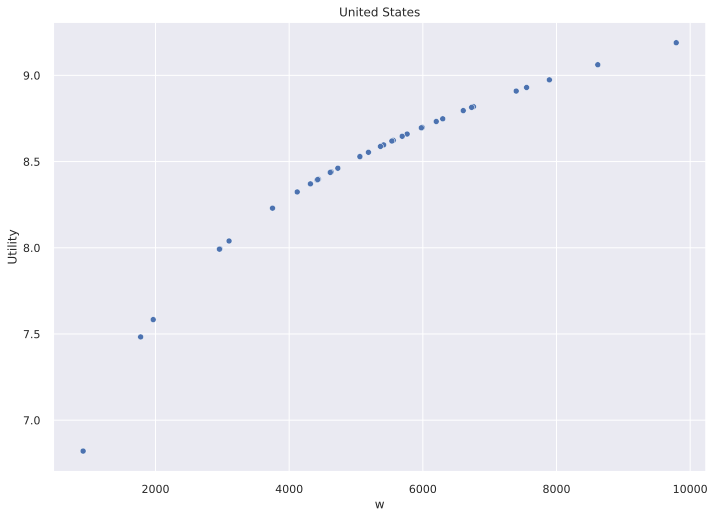

In [82]:
sns.scatterplot(data=plot_df, x="w", y="Utility", palette="deep").set_title('United States')

#### Orange

In [83]:
df = pd.read_excel("gdrive/MyDrive/風險管理/Return per acre.xlsx", sheet_name="Orange")

##### Florida

In [84]:
temp = df[df["State"] == "Florida"]
plot_df = pd.DataFrame()
plot_df["w"] = temp["Return per acre"]
plot_df["Utility"] = np.log(temp["Return per acre"])

Text(0.5, 1.0, 'Florida')

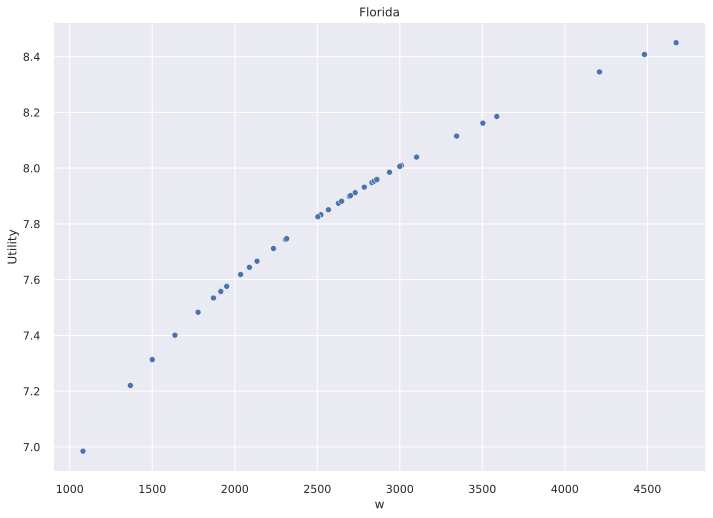

In [85]:
sns.scatterplot(data=plot_df, x="w", y="Utility", palette="deep").set_title('Florida')

##### California

In [86]:
temp = df[df["State"] == "California"]
plot_df = pd.DataFrame()
plot_df["w"] = temp["Return per acre"]
plot_df["Utility"] = np.log(temp["Return per acre"])

Text(0.5, 1.0, 'California')

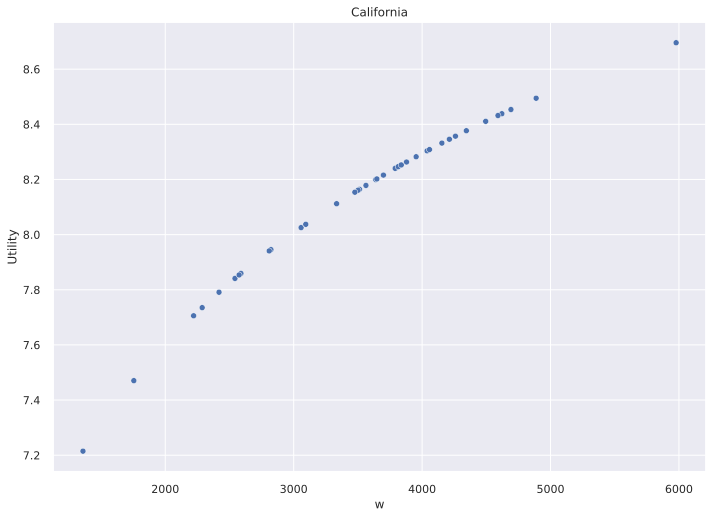

In [87]:
sns.scatterplot(data=plot_df, x="w", y="Utility", palette="deep").set_title('California')

##### Texas

In [88]:
temp = df[df["State"] == "Texas"]
plot_df = pd.DataFrame()
plot_df["w"] = temp["Return per acre"]
plot_df["Utility"] = np.log(temp["Return per acre"])

Text(0.5, 1.0, 'Texas')

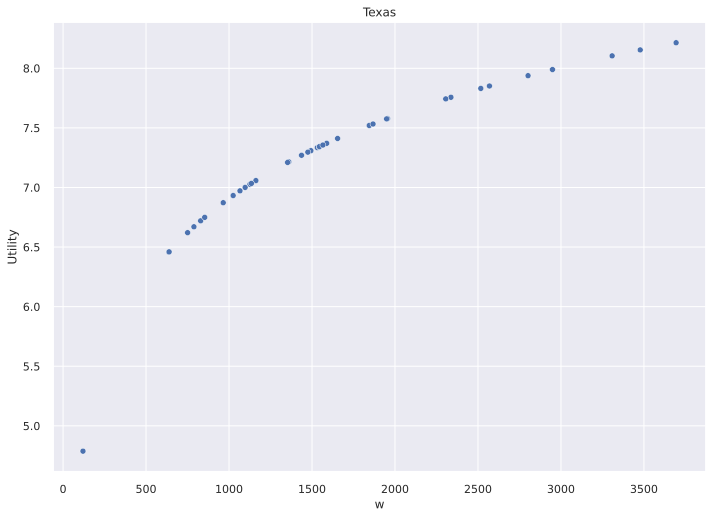

In [89]:
sns.scatterplot(data=plot_df, x="w", y="Utility", palette="deep").set_title('Texas')

##### Arizona

In [90]:
temp = df[df["State"] == "Arizona"]
plot_df = pd.DataFrame()
plot_df["w"] = temp["Return per acre"]
plot_df["Utility"] = np.log(temp["Return per acre"])

Text(0.5, 1.0, 'Arizona')

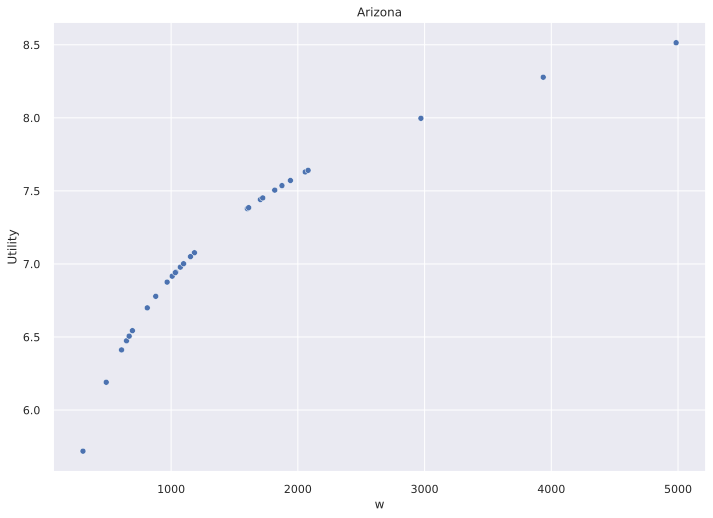

In [91]:
sns.scatterplot(data=plot_df, x="w", y="Utility", palette="deep").set_title('Arizona')

##### United States

In [92]:
temp = df[df["State"] == "United States"]
plot_df = pd.DataFrame()
plot_df["w"] = temp["Return per acre"]
plot_df["Utility"] = np.log(temp["Return per acre"])

Text(0.5, 1.0, 'United States')

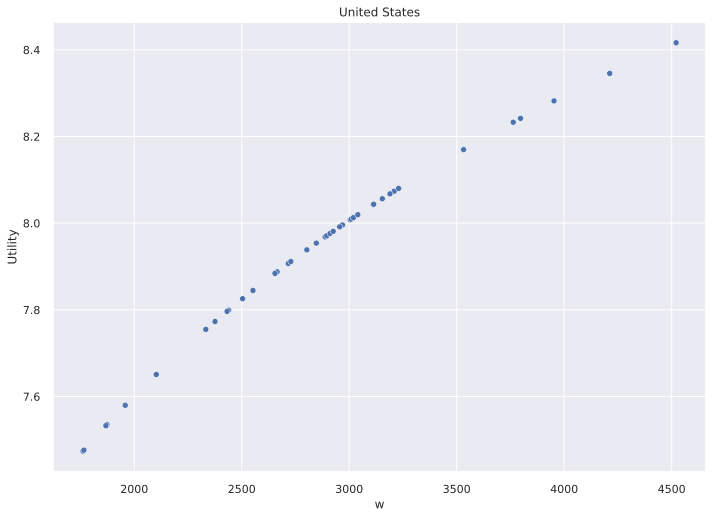

In [93]:
sns.scatterplot(data=plot_df, x="w", y="Utility", palette="deep").set_title('United States')

### CRRA Utility - Power

* Power: $U = \{1/(1 − r)\} w^{(1 − r)}, w > 0$

  for which $r_{r}(w) = r$ and $r_{a} = r/w$

#### Grapefruit


In [94]:
df = pd.read_excel("gdrive/MyDrive/風險管理/Return per acre.xlsx", sheet_name="Grapefruit")

##### Florida

In [95]:
sub_df = df[df["State"] == "Florida"]
plot_df = pd.DataFrame(columns=["w", "Utility", "Risk averse coef."])
# r: 0.1
temp_utility = (1/(1 - 0.1)) * sub_df["Return per acre"] ** (1 - 0.1)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.1})
plot_df = plot_df.append(temp)
# r: 0.5
temp_utility = (1/(1 - 0.5)) * sub_df["Return per acre"] ** (1 - 0.5)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.5})
plot_df = plot_df.append(temp)
# r - 0.9
temp_utility = (1/(1 - 0.9)) * sub_df["Return per acre"] ** (1 - 0.9)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.9})
plot_df = plot_df.append(temp)

Text(0.5, 1.0, 'Florida')

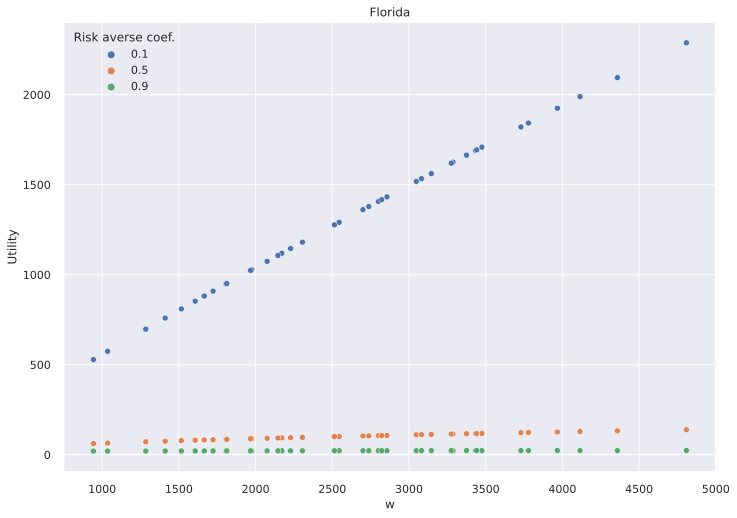

In [96]:
sns.scatterplot(data=plot_df, x="w", y="Utility", hue="Risk averse coef.", palette="deep").set_title('Florida')

##### California

In [97]:
sub_df = df[df["State"] == "California"]
plot_df = pd.DataFrame(columns=["w", "Utility", "Risk averse coef."])
# r: 0.1
temp_utility = (1/(1 - 0.1)) * sub_df["Return per acre"] ** (1 - 0.1)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.1})
plot_df = plot_df.append(temp)
# r: 0.5
temp_utility = (1/(1 - 0.5)) * sub_df["Return per acre"] ** (1 - 0.5)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.5})
plot_df = plot_df.append(temp)
# r - 0.9
temp_utility = (1/(1 - 0.9)) * sub_df["Return per acre"] ** (1 - 0.9)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.9})
plot_df = plot_df.append(temp)

Text(0.5, 1.0, 'California')

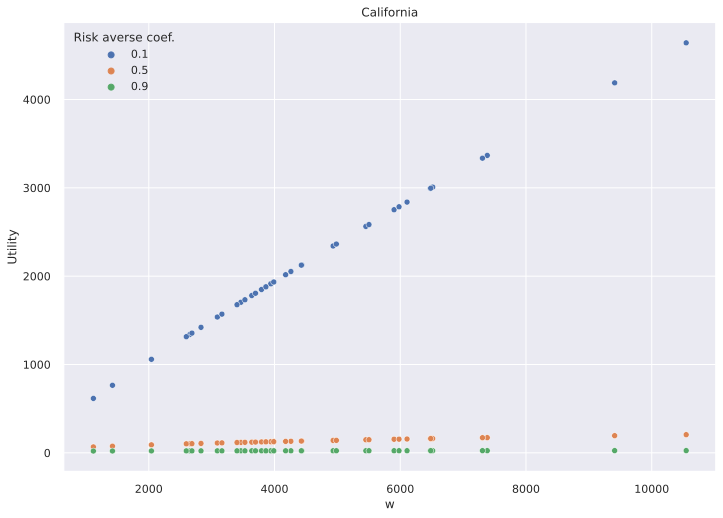

In [98]:
sns.scatterplot(data=plot_df, x="w", y="Utility", hue="Risk averse coef.", palette="deep").set_title('California')

##### Texas

In [99]:
sub_df = df[df["State"] == "Texas"]
plot_df = pd.DataFrame(columns=["w", "Utility", "Risk averse coef."])
# r: 0.1
temp_utility = (1/(1 - 0.1)) * sub_df["Return per acre"] ** (1 - 0.1)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.1})
plot_df = plot_df.append(temp)
# r: 0.5
temp_utility = (1/(1 - 0.5)) * sub_df["Return per acre"] ** (1 - 0.5)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.5})
plot_df = plot_df.append(temp)
# r - 0.9
temp_utility = (1/(1 - 0.9)) * sub_df["Return per acre"] ** (1 - 0.9)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.9})
plot_df = plot_df.append(temp)

Text(0.5, 1.0, 'Texas')

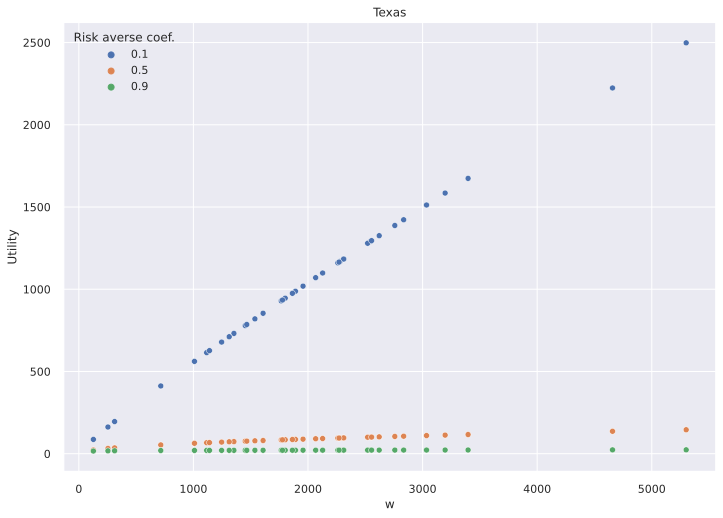

In [100]:
sns.scatterplot(data=plot_df, x="w", y="Utility", hue="Risk averse coef.", palette="deep").set_title('Texas')

##### Arizona

In [101]:
sub_df = df[df["State"] == "Arizona"]
plot_df = pd.DataFrame(columns=["w", "Utility", "Risk averse coef."])
# r: 0.1
temp_utility = (1/(1 - 0.1)) * sub_df["Return per acre"] ** (1 - 0.1)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.1})
plot_df = plot_df.append(temp)
# r: 0.5
temp_utility = (1/(1 - 0.5)) * sub_df["Return per acre"] ** (1 - 0.5)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.5})
plot_df = plot_df.append(temp)
# r - 0.9
temp_utility = (1/(1 - 0.9)) * sub_df["Return per acre"] ** (1 - 0.9)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.9})
plot_df = plot_df.append(temp)

Text(0.5, 1.0, 'Arizona')

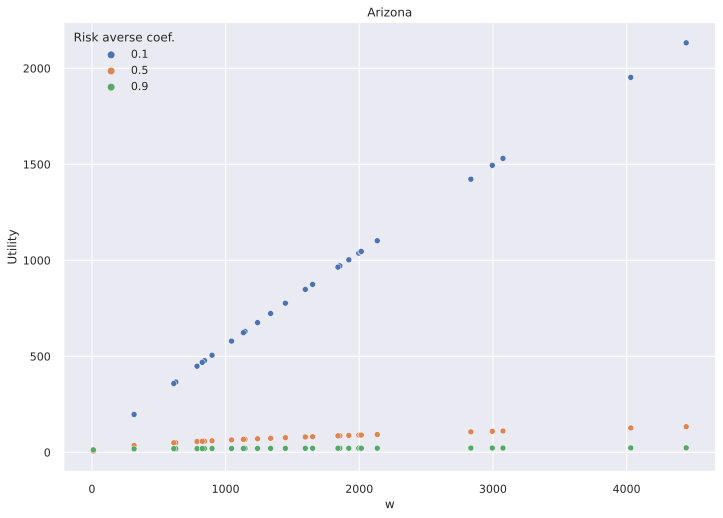

In [102]:
sns.scatterplot(data=plot_df, x="w", y="Utility", hue="Risk averse coef.", palette="deep").set_title('Arizona')

##### United States

In [103]:
sub_df = df[df["State"] == "United States"]
plot_df = pd.DataFrame(columns=["w", "Utility", "Risk averse coef."])
# r: 0.1
temp_utility = (1/(1 - 0.1)) * sub_df["Return per acre"] ** (1 - 0.1)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.1})
plot_df = plot_df.append(temp)
# r: 0.5
temp_utility = (1/(1 - 0.5)) * sub_df["Return per acre"] ** (1 - 0.5)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.5})
plot_df = plot_df.append(temp)
# r - 0.9
temp_utility = (1/(1 - 0.9)) * sub_df["Return per acre"] ** (1 - 0.9)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.9})
plot_df = plot_df.append(temp)

Text(0.5, 1.0, 'United States')

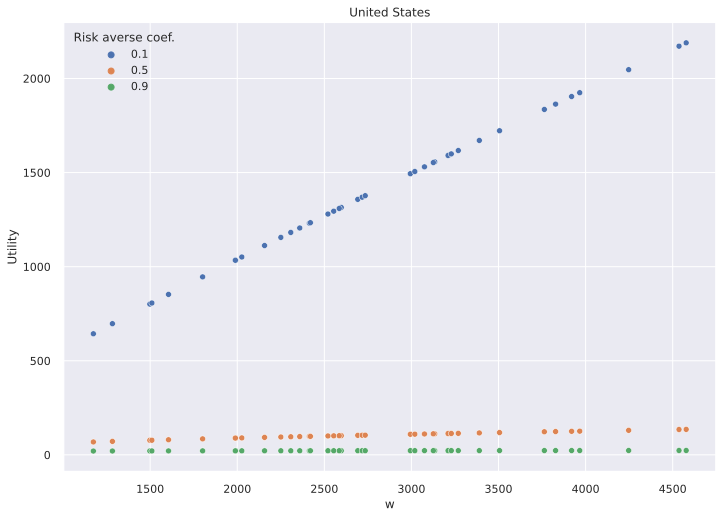

In [104]:
sns.scatterplot(data=plot_df, x="w", y="Utility", hue="Risk averse coef.", palette="deep").set_title('United States')

#### Lemon


In [105]:
df = pd.read_excel("gdrive/MyDrive/風險管理/Return per acre.xlsx", sheet_name="Lemon")

##### California

In [106]:
sub_df = df[df["State"] == "California"]
plot_df = pd.DataFrame(columns=["w", "Utility", "Risk averse coef."])
# r: 0.1
temp_utility = (1/(1 - 0.1)) * sub_df["Return per acre"] ** (1 - 0.1)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.1})
plot_df = plot_df.append(temp)
# r: 0.5
temp_utility = (1/(1 - 0.5)) * sub_df["Return per acre"] ** (1 - 0.5)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.5})
plot_df = plot_df.append(temp)
# r - 0.9
temp_utility = (1/(1 - 0.9)) * sub_df["Return per acre"] ** (1 - 0.9)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.9})
plot_df = plot_df.append(temp)

Text(0.5, 1.0, 'California')

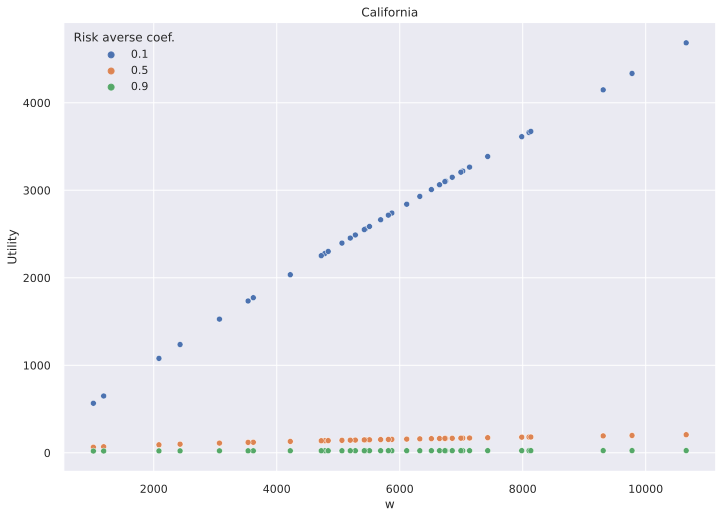

In [107]:
sns.scatterplot(data=plot_df, x="w", y="Utility", hue="Risk averse coef.", palette="deep").set_title('California')

##### Arizona

In [108]:
sub_df = df[df["State"] == "Arizona"]
plot_df = pd.DataFrame(columns=["w", "Utility", "Risk averse coef."])
# r: 0.1
temp_utility = (1/(1 - 0.1)) * sub_df["Return per acre"] ** (1 - 0.1)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.1})
plot_df = plot_df.append(temp)
# r: 0.5
temp_utility = (1/(1 - 0.5)) * sub_df["Return per acre"] ** (1 - 0.5)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.5})
plot_df = plot_df.append(temp)
# r - 0.9
temp_utility = (1/(1 - 0.9)) * sub_df["Return per acre"] ** (1 - 0.9)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.9})
plot_df = plot_df.append(temp)

Text(0.5, 1.0, 'Arizona')

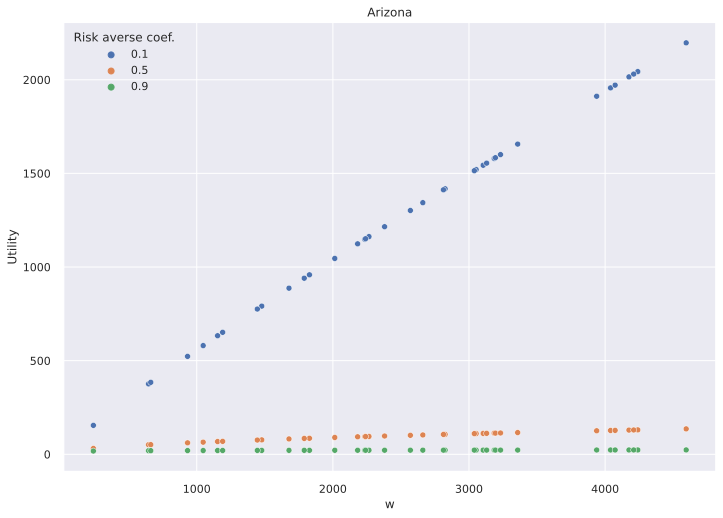

In [109]:
sns.scatterplot(data=plot_df, x="w", y="Utility", hue="Risk averse coef.", palette="deep").set_title('Arizona')

##### United States

In [110]:
sub_df = df[df["State"] == "United States"]
plot_df = pd.DataFrame(columns=["w", "Utility", "Risk averse coef."])
# r: 0.1
temp_utility = (1/(1 - 0.1)) * sub_df["Return per acre"] ** (1 - 0.1)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.1})
plot_df = plot_df.append(temp)
# r: 0.5
temp_utility = (1/(1 - 0.5)) * sub_df["Return per acre"] ** (1 - 0.5)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.5})
plot_df = plot_df.append(temp)
# r - 0.9
temp_utility = (1/(1 - 0.9)) * sub_df["Return per acre"] ** (1 - 0.9)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.9})
plot_df = plot_df.append(temp)

Text(0.5, 1.0, 'United States')

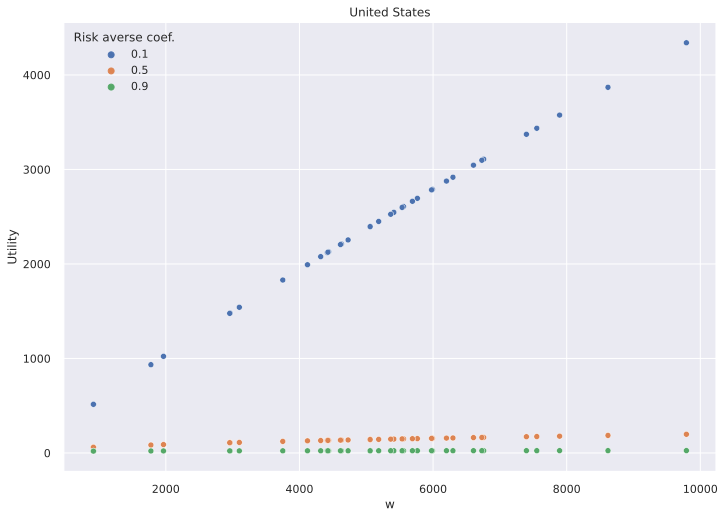

In [111]:
sns.scatterplot(data=plot_df, x="w", y="Utility", hue="Risk averse coef.", palette="deep").set_title('United States')

#### Orange


In [112]:
df = pd.read_excel("gdrive/MyDrive/風險管理/Return per acre.xlsx", sheet_name="Orange")

##### Florida

In [113]:
sub_df = df[df["State"] == "Florida"]
plot_df = pd.DataFrame(columns=["w", "Utility", "Risk averse coef."])
# r: 0.1
temp_utility = (1/(1 - 0.1)) * sub_df["Return per acre"] ** (1 - 0.1)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.1})
plot_df = plot_df.append(temp)
# r: 0.5
temp_utility = (1/(1 - 0.5)) * sub_df["Return per acre"] ** (1 - 0.5)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.5})
plot_df = plot_df.append(temp)
# r - 0.9
temp_utility = (1/(1 - 0.9)) * sub_df["Return per acre"] ** (1 - 0.9)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.9})
plot_df = plot_df.append(temp)

Text(0.5, 1.0, 'Florida')

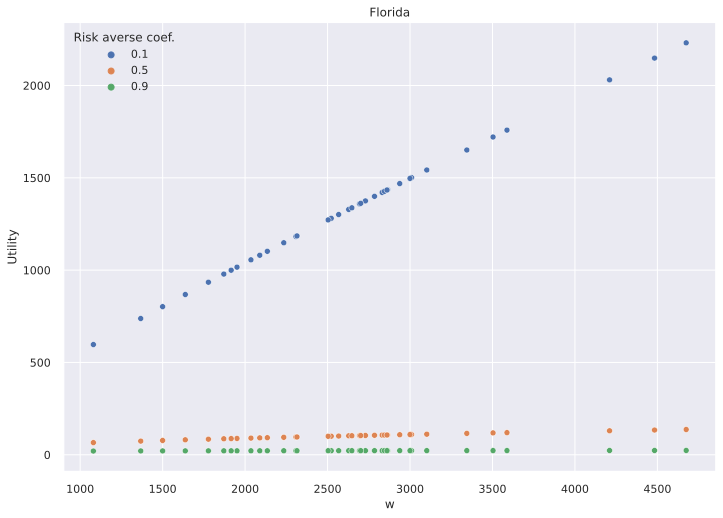

In [114]:
sns.scatterplot(data=plot_df, x="w", y="Utility", hue="Risk averse coef.", palette="deep").set_title('Florida')

##### California

In [115]:
sub_df = df[df["State"] == "California"]
plot_df = pd.DataFrame(columns=["w", "Utility", "Risk averse coef."])
# r: 0.1
temp_utility = (1/(1 - 0.1)) * sub_df["Return per acre"] ** (1 - 0.1)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.1})
plot_df = plot_df.append(temp)
# r: 0.5
temp_utility = (1/(1 - 0.5)) * sub_df["Return per acre"] ** (1 - 0.5)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.5})
plot_df = plot_df.append(temp)
# r - 0.9
temp_utility = (1/(1 - 0.9)) * sub_df["Return per acre"] ** (1 - 0.9)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.9})
plot_df = plot_df.append(temp)

Text(0.5, 1.0, 'California')

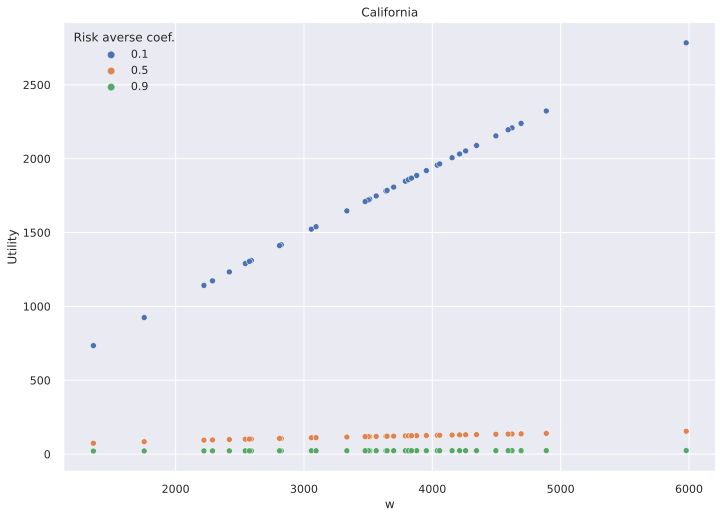

In [116]:
sns.scatterplot(data=plot_df, x="w", y="Utility", hue="Risk averse coef.", palette="deep").set_title('California')

##### Texas

In [117]:
sub_df = df[df["State"] == "Texas"]
plot_df = pd.DataFrame(columns=["w", "Utility", "Risk averse coef."])
# r: 0.1
temp_utility = (1/(1 - 0.1)) * sub_df["Return per acre"] ** (1 - 0.1)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.1})
plot_df = plot_df.append(temp)
# r: 0.5
temp_utility = (1/(1 - 0.5)) * sub_df["Return per acre"] ** (1 - 0.5)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.5})
plot_df = plot_df.append(temp)
# r - 0.9
temp_utility = (1/(1 - 0.9)) * sub_df["Return per acre"] ** (1 - 0.9)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.9})
plot_df = plot_df.append(temp)

Text(0.5, 1.0, 'Texas')

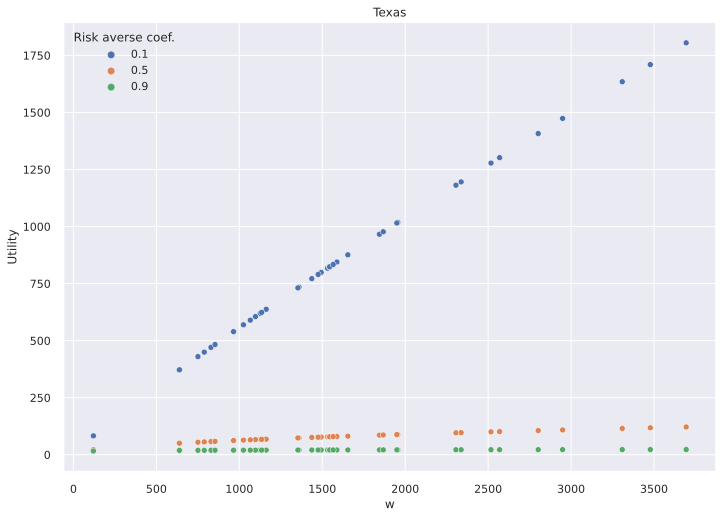

In [118]:
sns.scatterplot(data=plot_df, x="w", y="Utility", hue="Risk averse coef.", palette="deep").set_title('Texas')

##### Arizona

In [119]:
sub_df = df[df["State"] == "Arizona"]
plot_df = pd.DataFrame(columns=["w", "Utility", "Risk averse coef."])
# r: 0.1
temp_utility = (1/(1 - 0.1)) * sub_df["Return per acre"] ** (1 - 0.1)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.1})
plot_df = plot_df.append(temp)
# r: 0.5
temp_utility = (1/(1 - 0.5)) * sub_df["Return per acre"] ** (1 - 0.5)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.5})
plot_df = plot_df.append(temp)
# r - 0.9
temp_utility = (1/(1 - 0.9)) * sub_df["Return per acre"] ** (1 - 0.9)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.9})
plot_df = plot_df.append(temp)

Text(0.5, 1.0, 'Arizona')

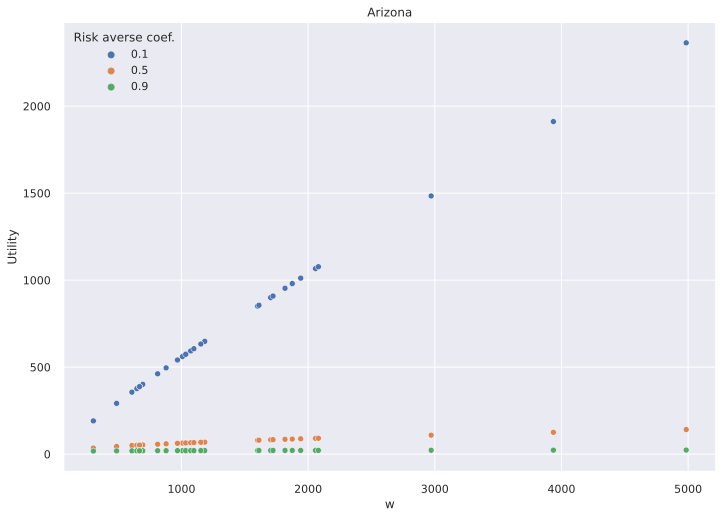

In [120]:
sns.scatterplot(data=plot_df, x="w", y="Utility", hue="Risk averse coef.", palette="deep").set_title('Arizona')

##### United States

In [121]:
sub_df = df[df["State"] == "United States"]
plot_df = pd.DataFrame(columns=["w", "Utility", "Risk averse coef."])
# r: 0.1
temp_utility = (1/(1 - 0.1)) * sub_df["Return per acre"] ** (1 - 0.1)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.1})
plot_df = plot_df.append(temp)
# r: 0.5
temp_utility = (1/(1 - 0.5)) * sub_df["Return per acre"] ** (1 - 0.5)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.5})
plot_df = plot_df.append(temp)
# r - 0.9
temp_utility = (1/(1 - 0.9)) * sub_df["Return per acre"] ** (1 - 0.9)
temp = pd.DataFrame({"w": sub_df["Return per acre"], "Utility": temp_utility, "Risk averse coef.": 0.9})
plot_df = plot_df.append(temp)

Text(0.5, 1.0, 'United States')

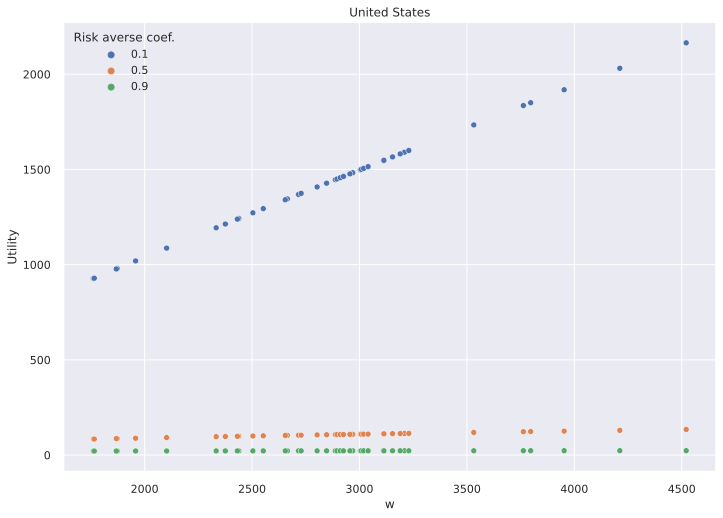

In [122]:
sns.scatterplot(data=plot_df, x="w", y="Utility", hue="Risk averse coef.", palette="deep").set_title('United States')

### Explain

* Q1: `CARA` 和 `CRRA - Power` 都可以用來 `examine the utility levels with different levels of risk aversion`

* Q2: 只有 `CRRA - Logarithmic` 可以在同一個水果的限制下比較不同的州，因為其 Utility函式中僅包含變數 `w` ，相較於其他函式中都有一個以上的變動因素，多因素同時在變動時是無法比較的

## Question 4

> As a thinking practice, if both Junior and Senior have the capital to choose their planting location, to choose which variety of Citrus fruit, and to choose which utilization will give the best economic performance. Suppose now the preferences are unknown and there is no best function to be used to characterize the production phase. What kind of graph will we need to generate to show the comparison across different risky prospects to aim for a stochastic dominance analysis, either it’s first- or second-degree? Use command cumul to generate the probabilistic distribution of the outcome variable. Put down your graphs, as accurately as you can, and identify the likely choices facing Junior and Senior. Briefly state your reason, and list out all the possible scenarios that you think most relevant for discussion.

我們可以使用 CDF 圖進行stochastic dominance analysis

### CDF

#### Grapefruit

In [123]:
df = pd.read_excel("gdrive/MyDrive/風險管理/Return per acre.xlsx", sheet_name="Grapefruit")
# Fill N/A with 0
df = df.fillna(0)

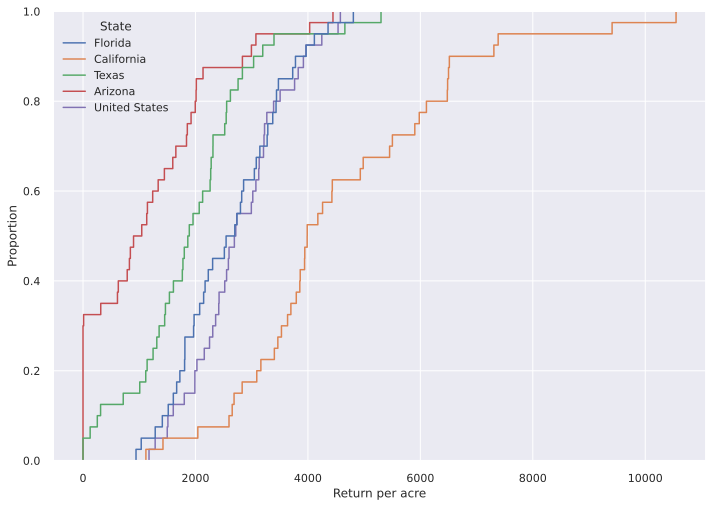

In [124]:
sns.ecdfplot(data=df, x="Return per acre", hue="State")

#### Lemon

In [125]:
df = pd.read_excel("gdrive/MyDrive/風險管理/Return per acre.xlsx", sheet_name="Lemon")
# Fill N/A with 0
df = df.fillna(0)

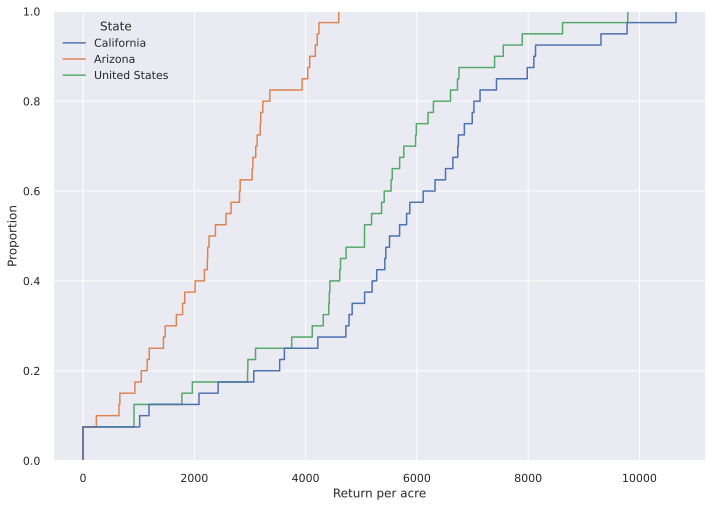

In [126]:
sns.ecdfplot(data=df, x="Return per acre", hue="State")

#### Orange

In [127]:
df = pd.read_excel("gdrive/MyDrive/風險管理/Return per acre.xlsx", sheet_name="Orange")
# Fill N/A with 0
df = df.fillna(0)

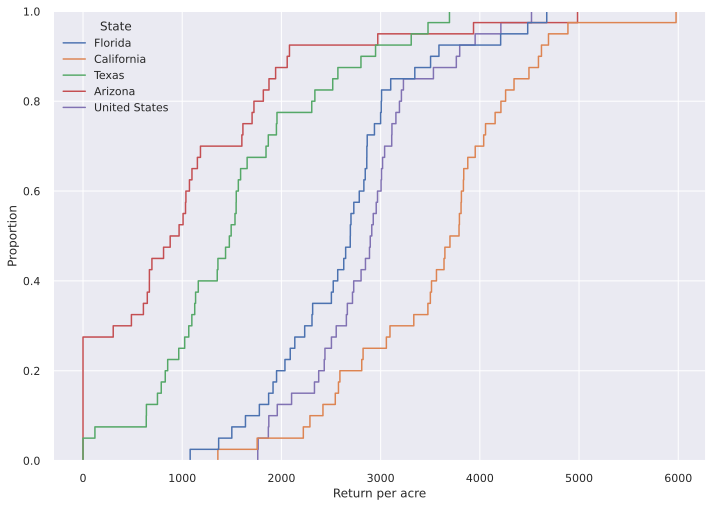

In [128]:
sns.ecdfplot(data=df, x="Return per acre", hue="State")

### Explain

在上面個作物之CDF圖中，`First-degree stochastic dominance (FSD)` 僅能在線段不交會的情況下進行比較，換句話說，如 `Grapefruit` 中 `Florida` 和 `United States` 線段有交會到，在FSD下兩者並無法比較得知誰較優；而在 `Second-degree stochastic dominance (SSD)` 下，SSD 在 FSD 之上更近一步比較兩條線的底下的面積，解決了部分情況在FSD下無法比較的窘境。
當然了，`SSD` 亦有其限制存在，也有人提出 `TSD` 解決方案，但 TSD 的成效並不如 SSD 之於 FSD 般明顯，故我們並未使用 TSD 進行分析。

## Question 5


> **Seasonal prices** for fruits is critical - Go to the data on per-box monthly equivalent- on-tree returns: Focus on grapefruit in California, given the fact that the marketing season start from 11/1 in previous year to 10/31 in the next year, what could it imply for fluctuation in prices? Compared with its yield data, which month(s) most accurately depict the classic relationship between supply price and quantity? What are the possible risks facing citrus fruit growers? Could we locate the risk corresponding to the dropping yields at certain point of time?

> Set up a simulation program to simulate the price given 100 observations, following a lognormal distribution. Show the summary statistics from your experiment. Can we truly replicate the original price series pattern from September to December by performing the experiment 1000 times? (Play some try-and-error.)

### Fluctuation in prices

從 Annual Summary 的資訊中我們可以得知，**1月底至2月份可能會發生霜害**，進而影響產量，農產 time lag 的特性使得價格到3月份後才顯現在價格上；而**8, 9月的颶風** 也會使得價格上漲

In [129]:
# PPI
ppi_df = pd.read_excel("gdrive/MyDrive/風險管理/PPI.xlsx", sheet_name="PPI")
ppi = ppi_df["2015 base PPI"]

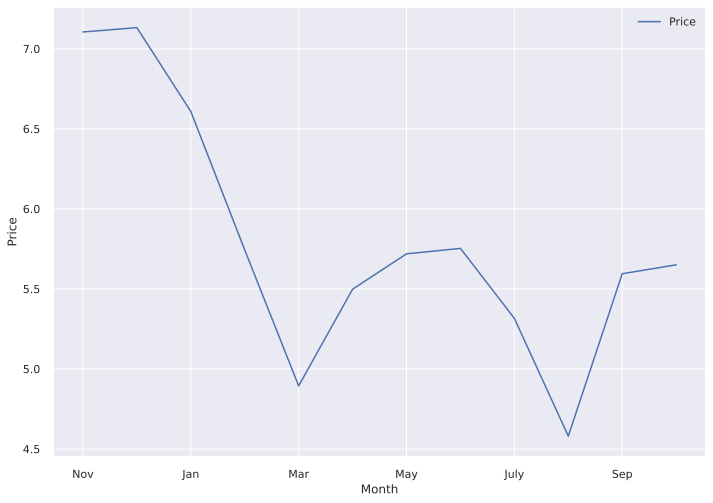

In [130]:
df = pd.read_excel("gdrive/MyDrive/風險管理/Trend.xlsx", sheet_name="Month Trend")
del df["Year"]
del df["Unnamed: 13"]
del df["Unnamed: 14"]
df = df.iloc[:40]
plot_data = {}
for each in df:
    plot_data[each] = (df[each] * ppi).mean()
    df[each] *= ppi
pd.DataFrame.from_dict(plot_data, orient='index', columns=["Price"]).plot.line(xlabel="Month", ylabel="Price")

### Which month(s) most accurately depict the classic relationship between supply price and quantity?

從資料中我們可以觀察到，`June` 和 `July` 和年度價格的 MSE 是最小的 (其中 `June: 2.438984`) 是最小的

故我們選擇使用 `June` 作為代表月份

In [131]:
df = pd.read_excel("gdrive/MyDrive/風險管理/Trend.xlsx", sheet_name="Year Trend")
del df["Year"]

result = pd.DataFrame(columns=["Month", "MSE"])

for each in df.columns[1:]:
    # Fill N/A with mean
    df[each] = df[each].fillna(df[each].mean())
    temp = pd.DataFrame({"Month": each, "MSE": mean_squared_error(df["California"] * ppi[:40], df[each]* ppi[:40])}, index=[0])
    result = result.append(temp)
result

,Month,MSE
0,Nov,12.907137
0,Dec,13.807945
0,Jan,11.542190
0,Feb,8.959618
0,Mar,5.348832
0,Apr,4.505816
0,May,3.244188
0,June,2.438984
0,July,2.860963
0,Aug,6.658194


### What are the possible risks facing citrus fruit growers? Could we locate the risk corresponding to the dropping yields at certain point of time?

Possible risk:
1. 黃龍病
2. 霜害
3. 颶風

氣候災害如 `霜害`, `颶風` 等會反映在價格上，我們可以從`equivalent-on-tree returns` 資料中價格的波動上觀察到；而其他如黃龍病等是並無時間上的規律性，全年皆有可能發生，較難從資料中觀察得知

### Simulation program

In [132]:
df = pd.read_excel("gdrive/MyDrive/風險管理/Trend.xlsx", sheet_name="Year Trend")
df = df[["Sep", "Oct", "Nov", "Dec"]]
# Fill N/A with mean
df = df.fillna(df.mean())

df.describe()

,Sep,Oct,Nov,Dec
count,40.000000,40.000000,40.000000,40.000000
mean,7.559474,7.285789,8.627000,8.570750
std,3.962710,4.801986,4.901102,4.922928
min,1.030000,1.100000,1.650000,1.460000
25%,4.665000,4.062500,6.027500,5.935000
50%,7.490000,6.700000,7.755000,7.340000
75%,9.597500,9.175000,10.012500,9.670000
max,16.770000,24.120000,21.140000,21.740000


#### Sep
$\mu=7.559474, \sigma=3.962710$，當 $\mu=5.205, \sigma=4.049$ 的時候可以逼近原始資料長相

In [133]:
# Random config
np.random.seed(seed)
mu, sigma = lognorm_params(5.205, 4.049)

result = pd.DataFrame(columns=["mean", "std"])

for _ in range(1000):
    randan_data = np.random.lognormal(mean=mu, sigma=sigma, size=100)
    result = result.append({"mean": np.mean(randan_data),
                            "std": np.std(randan_data)},
                           ignore_index=True)
result.describe()

,mean,std
count,1000.000000,1000.000000
mean,7.557535,3.962626
std,0.399414,0.529427
min,6.505996,2.643479
25%,7.274400,3.607445
50%,7.541119,3.908389
75%,7.806487,4.285163
max,9.056363,6.545958


#### Oct
$\mu=7.285789, \sigma=4.801986$，當 $\mu=4.169, \sigma=4.396$ 的時候可以逼近原始資料長相

In [134]:
# Random config
np.random.seed(seed)
mu, sigma = lognorm_params(4.169, 4.936)

result = pd.DataFrame(columns=["mean", "std"])

for _ in range(1000):
    randan_data = np.random.lognormal(mean=mu, sigma=sigma, size=100)
    result = result.append({"mean": np.mean(randan_data),
                            "std": np.std(randan_data)},
                           ignore_index=True)
result.describe()

,mean,std
count,1000.000000,1000.000000
mean,7.285549,4.801161
std,0.486261,0.789710
min,6.009228,2.973378
25%,6.938390,4.255489
50%,7.255260,4.700910
75%,7.595594,5.241760
max,9.127089,9.406896


#### Nov
$\mu=8.627000, \sigma=4.901102$，當 $\mu=5.609, \sigma=5.017$ 的時候可以逼近原始資料長相

In [135]:
# Random config
np.random.seed(seed)
mu, sigma = lognorm_params(5.609, 5.017)

result = pd.DataFrame(columns=["mean", "std"])

for _ in range(1000):
    randan_data = np.random.lognormal(mean=mu, sigma=sigma, size=100)
    result = result.append({"mean": np.mean(randan_data),
                            "std": np.std(randan_data)},
                           ignore_index=True)
result.describe()

,mean,std
count,1000.000000,1000.000000
mean,8.627077,4.901085
std,0.494697,0.701625
min,7.324851,3.192434
25%,8.278142,4.421322
50%,8.601971,4.824585
75%,8.933656,5.318432
max,10.489914,8.545283


#### Dec
$\mu=8.570750, \sigma=4.922928$，當 $\mu=5.526, \sigma=5.04$ 的時候可以逼近原始資料長相

In [136]:
# Random config
np.random.seed(seed)
mu, sigma = lognorm_params(5.526, 5.04)

result = pd.DataFrame(columns=["mean", "std"])

for _ in range(1000):
    randan_data = np.random.lognormal(mean=mu, sigma=sigma, size=100)
    result = result.append({"mean": np.mean(randan_data),
                            "std": np.std(randan_data)},
                           ignore_index=True)
result.describe()

,mean,std
count,1000.000000,1000.000000
mean,8.570849,4.922224
std,0.496935,0.711496
min,7.262844,3.195312
25%,8.218392,4.435361
50%,8.545237,4.845823
75%,8.878236,5.343768
max,10.442961,8.649125


## Question 6

> **Price ratio** - Go back to production data: First locate the new piece of information on grower price at the same place where you find the data for your Citrus Fruit study. Derive ratio of equivalent-on-tree returns and grower price. Several things to keep in mind: be aware of the difference between these two datasets, and find their common ground to generate this ratio. (You will need to look at the datasets closely to make things go smoothly.) ~~What’s the type of ratio that can be derived to achieve the objective here? Refer to the Annual Report in the Folder again, interpret the ratio and its change over time.~~

> Set up a simulation program to simulate the ratio of prices from two datasets, suppose each sample comes from a lognormal distribution. The program requires six arguments as inputs. Set each sample observations of 100, use the mean and variance from actual data on the two price series stated above in your simulation. Simulate three types of ratio: Ratio of 10th percentile, ratio of mean, ratio of 90th percentile, with a 1000-times experiment. Show the summary statistics. Does the result change when we select new values for arguments for mean and variance for these two datasets, 0.7, 0.85, 0.08, 0.09?

### Price ratio

從資料我們可以觀察到，`equivalent-on-tree returns` 和 `grower price` 間的比例和年份並無很明顯的關係，起起伏伏並無明顯規律

In [137]:
df = pd.read_excel("gdrive/MyDrive/風險管理/Ratio.xlsx", sheet_name="Ratio")
df

,Year,Grower Price (Dollars / pounds),US Fresh Equivalent-on-tree returns (Dollars / box),Box weight (pounds)
0,1989/90,0.14,10.00,84.154023
1,1990/91,0.11,8.74,85.316420
2,1991/92,0.10,8.34,85.686844
3,1992/93,0.07,5.10,84.928946
4,1993/94,0.08,5.61,85.213107
5,1994/95,0.07,4.40,85.257496
6,1995/96,0.07,4.36,85.541338
7,1996/97,0.07,4.25,84.479476
8,1997/98,0.08,4.64,84.763685
9,1998/99,0.10,6.12,85.829833


Grower Price 敘述統計

In [138]:
df["Grower Price (Dollars / pounds)"].describe()

count    31.000000
mean      0.127097
std       0.058889
min       0.070000
25%       0.080000
50%       0.110000
75%       0.140000
max       0.280000
Name: Grower Price (Dollars / pounds), dtype: float64

Fresh Equivalent-on-tree returns 敘述統計

In [139]:
(df["US Fresh Equivalent-on-tree returns (Dollars / box)"] / df["Box weight (pounds)"]).describe()

count    31.000000
mean      0.119687
std       0.061901
min       0.050308
25%       0.068569
50%       0.108350
75%       0.138644
max       0.259559
dtype: float64

In [140]:
ratio = df["Grower Price (Dollars / pounds)"] / (df["US Fresh Equivalent-on-tree returns (Dollars / box)"] / df["Box weight (pounds)"])
ratio_df = pd.DataFrame({"Year": df["Year"], "Ratio": ratio})
ratio_df

,Year,Ratio
0,1989/90,1.178156
1,1990/91,1.073776
2,1991/92,1.027420
3,1992/93,1.165691
4,1993/94,1.215160
5,1994/95,1.356369
6,1995/96,1.373370
7,1996/97,1.391427
8,1997/98,1.461443
9,1998/99,1.402448


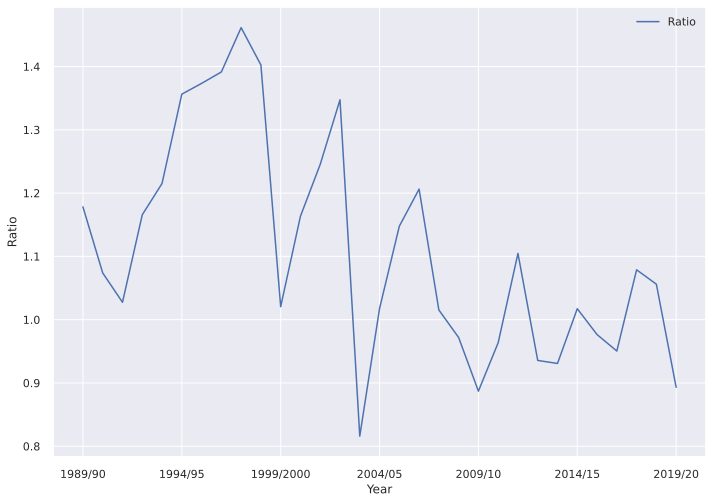

In [141]:
ratio_df.plot.line(x="Year", y="Ratio", xlabel="Year", ylabel="Ratio")

### Simulation program

從結果中可以觀察到，$\mu_1=0.7, \sigma_1^2=0.08$ 和 $mu_2=0.85, \sigma_2^2=0.09$ 的模擬結果相較原本的資料，其各個百分位距和平均數的 `mean` 和 `std` 都有明顯的下降，且從直方圖上觀察，資料似乎出現向左偏移的趨勢

#### $\mu_1=0.127, \sigma_1^2=0.058$, $\mu_2=0.12, \sigma_2^2=0.061$

In [142]:
# 固定seed
np.random.seed(seed)

result = pd.DataFrame(columns=["10th percentile", "mean", "90th percentile"])

for _ in range(1000):
    # 第一組數據
    mu, sigma = lognorm_params(0.127, 0.058)
    random_one = np.random.lognormal(mean=mu, sigma=sigma, size=100)
    # 第二組數據
    mu, sigma = lognorm_params(0.12, 0.061)
    random_two = np.random.lognormal(mean=mu, sigma=sigma, size=100)

    result = result.append({"10th percentile": np.percentile(random_one, 10) / np.percentile(random_two, 10),
                            "mean": np.mean(random_one) / np.mean(random_two),
                            "90th percentile": np.percentile(random_one, 90) / np.percentile(random_two, 90)},
                           ignore_index=True)

pd.DataFrame.from_dict(result).describe()

,10th percentile,mean,90th percentile
count,1000.000000,1000.000000,1000.000000
mean,1.078263,1.028802,1.007314
std,0.096703,0.057424,0.088951
min,0.770488,0.861009,0.695470
25%,1.015695,0.991036,0.947840
50%,1.071270,1.026426,1.004418
75%,1.141484,1.064210,1.066839
max,1.446643,1.270942,1.317118


##### histogram

###### 10th percentile

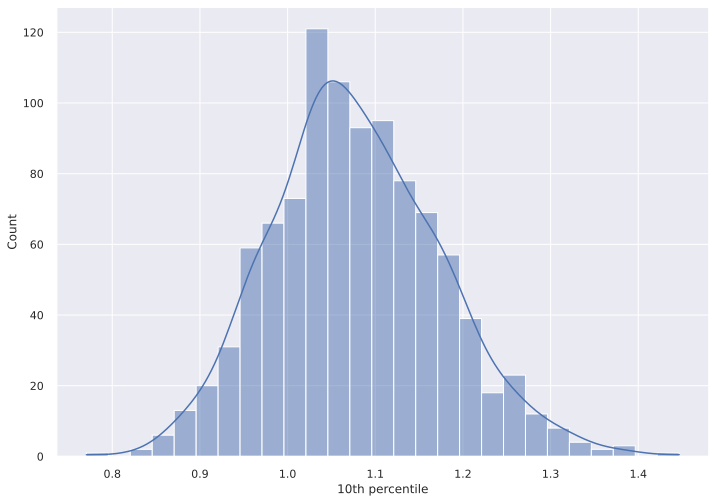

In [143]:
sns.histplot(data=result["10th percentile"], kde=True)

###### mean

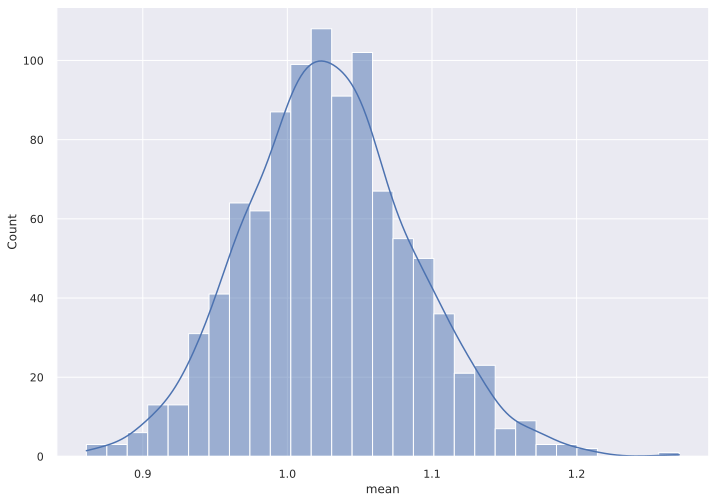

In [144]:
sns.histplot(data=result["mean"], kde=True)

###### 90th percentile

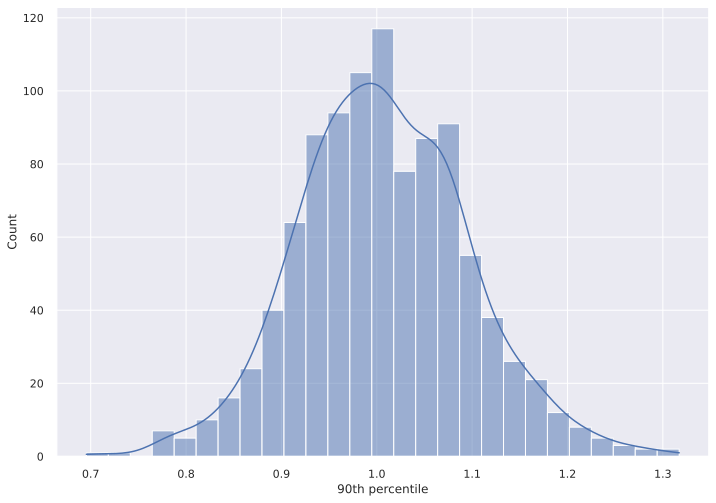

In [145]:
sns.histplot(data=result["90th percentile"], kde=True)

#### $\mu_1=0.7, \sigma_1^2=0.08$, $\mu_2=0.85, \sigma_2^2=0.09$

In [146]:
# 固定seed
np.random.seed(seed)

result = pd.DataFrame(columns=["10th percentile", "mean", "90th percentile"])

for _ in range(1000):
    # 第一組數據
    mu, sigma = lognorm_params(0.7, np.sqrt(0.08))
    random_one = np.random.lognormal(mean=mu, sigma=sigma, size=100)
    # 第二組數據
    mu, sigma = lognorm_params(0.85, np.sqrt(0.09))
    random_two = np.random.lognormal(mean=mu, sigma=sigma, size=100)

    result = result.append({"10th percentile": np.percentile(random_one, 10) / np.percentile(random_two, 10),
                            "mean": np.mean(random_one) / np.mean(random_two),
                            "90th percentile": np.percentile(random_one, 90) / np.percentile(random_two, 90)},
                           ignore_index=True)

pd.DataFrame.from_dict(result).describe()

,10th percentile,mean,90th percentile
count,1000.000000,1000.000000,1000.000000
mean,0.810661,0.849853,0.877196
std,0.061378,0.039661,0.065507
min,0.611772,0.734970,0.643090
25%,0.771076,0.824798,0.833706
50%,0.806426,0.848944,0.875609
75%,0.851925,0.874312,0.921566
max,1.036868,1.020202,1.103631


##### histogram

###### 10th percentile

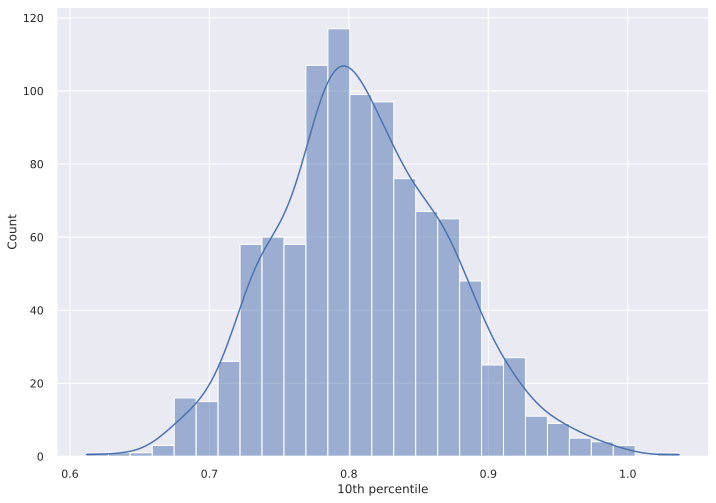

In [147]:
sns.histplot(data=result["10th percentile"], kde=True)

###### mean

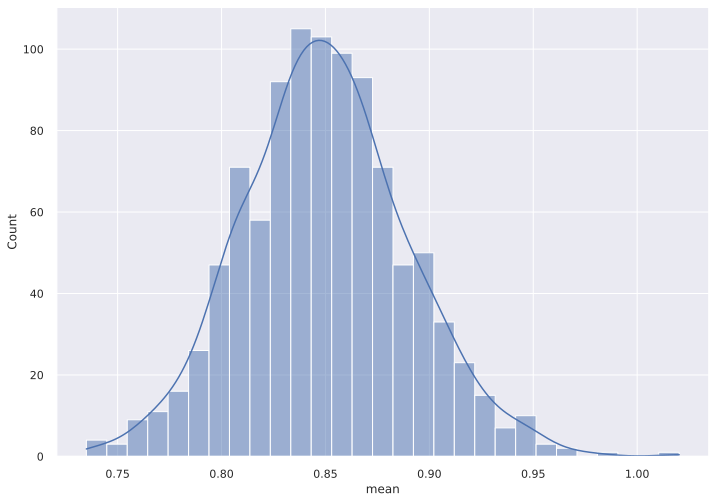

In [148]:
sns.histplot(data=result["mean"], kde=True)

###### 90th percentile

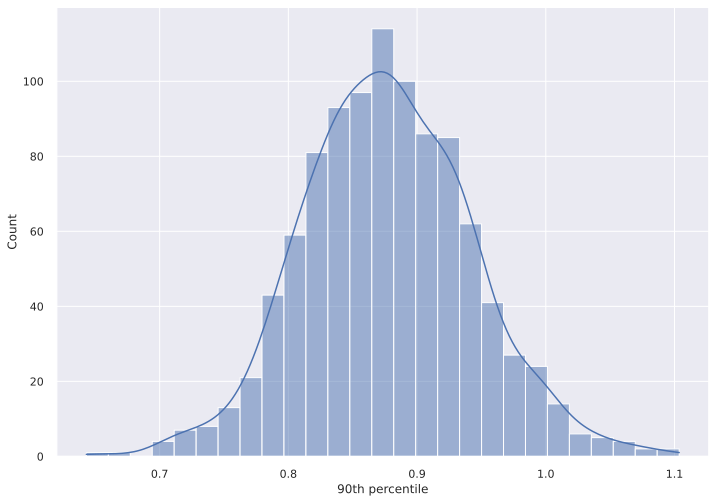

In [149]:
sns.histplot(data=result["90th percentile"], kde=True)